#1. INTRODUCTION

This script will contain a complete pipeline from text to BPMN diagram that uses ```BERT base cased``` for the NER task, ```CATBOOST``` for the RE and the ```en_coreference_web_trf``` pretrained model from spacy-experimental used for coreference resolution. The script will load a pre-trained model. Refer to the latest colab for NER (```CrossValidation with BERT base cased```) and RE (```CatBoost_Crossvalidation_RE.ipynb```) to train and save the models.

The purpose of this colab is to test the performance of this pipeline against the goldstandard information models.

In [ ]:
#@title Google Colab & Input Variables
#@markdown Please select the desired PATH
%%capture
import os
import json
import copy
import gdown
flag_model_loading = '/content/model_loading_flag'
# Check if the flag file exists
if not os.path.exists(flag_model_loading):
  # List of Google Drive links, viewer mode only.
  links = {'CATBOOST_FULLDATA':'https://drive.google.com/file/d/1a5JGJVwM9KGWOZsqszfE0gpzeeoPuAH8/view?usp=share_link',
          'BERT_MODEL_FULLDATA':'https://drive.google.com/drive/folders/1-5PS_Rmu58QCstMquakjeQM0NufOOF0i?usp=share_link',
          'BERT_TOKENIZER_FULLDATA':'https://drive.google.com/drive/folders/1-GlY0MjXZkhikb9lfAWCP_0gouGWJ_1L?usp=share_link',
          'BERT_MODEL_BASE_UNCASED_6DOCS_OUT':'https://drive.google.com/drive/folders/1-Kj7wx52mc6jXzJhSiv80qBkUW4RawFO?usp=share_link',
          'BERT_MODEL_BASE_CASED_6DOCS_OUT':'https://drive.google.com/drive/folders/1-UQn4fDBghbBu_Ysl5gzplmTDxDc7QhB?usp=share_link',
          'BERT_TOKENIZER_BASE_UNCASED_6DOCS_OUT': 'https://drive.google.com/drive/folders/1-GgGZBruoqJBrTGB-QJV9beOnZHNQjSi?usp=share_link',
          'BERT_TOKENIZER_BASE_CASED_6DOCS_OUT': 'https://drive.google.com/drive/folders/1-Cem5F1Dwxe2NdzsmnQcvkP4L9IOtdtH?usp=share_link',
          'CATBOOST_6DOCS_OUT': 'https://drive.google.com/file/d/1MFWeI73gJRGjRpX6RgV-lXVTCJsfg-4L/view?usp=share_link',
          'BERT_MODEL_DOC20_15_OUT': 'https://drive.google.com/drive/folders/1vHu8vxJVNidU6lEsSWY-dCEx1KAnyFP1?usp=share_link',
          'BERT_TOKENIZER_DOC20_15_OUT': 'https://drive.google.com/drive/folders/1vHu8vxJVNidU6lEsSWY-dCEx1KAnyFP1?usp=share_link',
          'CATBOOST_DOC15_OUT': 'https://drive.google.com/file/d/1Roub03hQMSDk_AmTyRDM3UX3Ult6xBD9/view?usp=share_link'
          }
  # Function to extract ID from shareable link
  def extract_id(shareable_link):
      if 'file/d/' in shareable_link:
          return shareable_link.split('/file/d/')[1].split('/')[0]
      elif 'drive/folders/' in shareable_link:
          return shareable_link.split('/drive/folders/')[1].split('?')[0]
      else:
          raise ValueError("Invalid shareable link")

  # Function to download content based on ID type
  def download_content(shareable_link, destination):
      file_or_folder_id = extract_id(shareable_link)
      if 'file/d/' in shareable_link:
          url = f"https://drive.google.com/uc?id={file_or_folder_id}"
          gdown.download(url, destination, quiet=True)
      elif 'drive/folders/' in shareable_link:
          gdown.download_folder(id=file_or_folder_id, output=destination)
      else:
          raise ValueError("Invalid shareable link")

  # Define the variables using simpler names
  BERT_MODEL_SELECTION = "BERT_MODEL_BASE_CASED_6DOCS_OUT" #@param ["BERT_MODEL_BASE_UNCASED_6DOCS_OUT", "BERT_MODEL_BASE_CASED_6DOCS_OUT", "BERT_MODEL_DOC20_15_OUT"] {type:"string"}
  BERT_TOKENIZER_SELECTION = "BERT_TOKENIZER_BASE_CASED_6DOCS_OUT" #@param ["BERT_TOKENIZER_BASE_UNCASED_6DOCS_OUT", "BERT_TOKENIZER_BASE_CASED_6DOCS_OUT", "BERT_TOKENIZER_DOC20_15_OUT"] {type:"string"}
  CATBOOST_MODEL_SELECTION = "CATBOOST_6DOCS_OUT" #@param ["CATBOOST_6DOCS_OUT", "CATBOOST_DOC15_OUT"] {type:"string"}

  selection = {
    "BERT_MODEL": links[BERT_MODEL_SELECTION],
    "BERT_TOKENIZER": links[BERT_TOKENIZER_SELECTION],
    "CATBOOST_MODEL": links[CATBOOST_MODEL_SELECTION]}

  # Download each link to the specified destination
  for key, value in selection.items():
      destination = f'/content/{key}'
      download_content(value, destination)


  BERT_MODEL_PATH = '/content/BERT_MODEL'
  BERT_TOKENIZER_PATH = '/content/BERT_TOKENIZER'
  CATBOOST_MODEL_PATH = '/content/CATBOOST_MODEL'




  # Create the flag file to indicate that imports have been done
  with open(flag_model_loading, 'w') as f:
      f.write('Model Loaded')

else:
    print("Model already loaded. Skipping step.")
print("All downloads completed!")


Now we load the **testing data**. These documents were kept separate before training BERT. Refer to section 3 in "```CrossValidation with BERT base cased```" for the code. Note that this testing data will also be used for Relational Extraction and in the rest of this pipeline. See folder '/FINAL/Data/DEPENDENCIES/' for other testing docs


In [ ]:
#@title Testing Document Input
#@markdown Please select a testing document
#@markdown **note that if you chose the 6DOC_OUT BERT model you cannot select document 20.15**
def load_and_group_ner_data(file_path):
    grouped_data = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            document_name = entry['document name']  # Adjusted to use 'document name'
            if document_name not in grouped_data:
                grouped_data[document_name] = []
            grouped_data[document_name].append(entry)

    # Sort each group by 'sentence-ID'
    for doc in grouped_data.values():
        doc.sort(key=lambda x: x['sentence-ID'])

    return list(grouped_data.values())

class ModelDocConflict(Exception):
    def __init__(self):
        self.message = "You are trying to select a document which the model has seen before! Either select another model or another document."
        super().__init__(self.message)

testing_documents = {'document_1.json': 'https://drive.google.com/file/d/1-UJ2WSglf7lZCflRP0yW2eDGBpF4Bxhu/view?usp=share_link',
                     'document_2.json': 'https://drive.google.com/file/d/1-cI4jrLVn8MPIfV6AmufXEeiYvT7Ku8m/view?usp=share_link',
                     'document_3.json': 'https://drive.google.com/file/d/1-_p2zV_hU6Vn_sKwfs7CNY_hfLvkIkvx/view?usp=share_link',
                     'document_4.json': 'https://drive.google.com/file/d/1-_So5HZ_b2JuJuR7MY6Mk18l9WNMmDPn/view?usp=share_link',
                     'document_5.json': 'https://drive.google.com/file/d/1-_RqmR9c2GL5YzKRI9aiKSD4yntcYXdu/view?usp=share_link',
                     'document_6.json': 'https://drive.google.com/file/d/1-V1y5_i4d_3MGguhAgkuzhRfuXU2RMPx/view?usp=share_link',
                     'doc-20.15 - library request.json': 'https://drive.google.com/file/d/1-ASmXjjGG9j3aVFLUCtvt9N3qyWzlWkQ/view?usp=share_link'}


document_name_selection = 'document_6.json' #@param ['document_1.json', 'document_2.json', 'document_3.json', 'document_4.json', 'document_5.json', 'document_6.json', 'doc-20.15 - library request.json'] {type:"string"}

selection = {
    "TESTING_DOC": testing_documents[document_name_selection]}

# Download each link to the specified destination
for key, value in selection.items():
    destination = f'/content/{key}'
    download_content(value, destination)

file_path = '/content/TESTING_DOC'

if document_name_selection == 'doc-20.15 - library request.json' and BERT_MODEL_PATH == BERT_MODEL_6DOCS_OUT:
  raise ModelDocConflict

test_input_data = load_and_group_ner_data(file_path)
flat_data = [item for group in test_input_data for item in group]
testing_doc_name = copy.deepcopy(flat_data[0]['document name'])


In [ ]:
#@title goldstandard data use selection
goldstandard_NER_check = "False" #@param ["True", "False"] {type: "string"}
goldstandard_RE_check = "False" #@param ["True", "False"] {type: "string"}

use_goldstandardNER= False
if goldstandard_NER_check == "True":
  use_goldstandardNER = True

use_goldstandardRE = False
if goldstandard_RE_check == "True":
  use_goldstandardRE = True

In [ ]:
#@title Installations and Downloads (takes 4 minutes)
%%capture
# Define the path to the flag file, we do this so you can rerun the whole colab on different examples without having to wait 4 minutes each time.
flag_file_installations = '/content/installed_flag'

# Check if the flag file exists
if not os.path.exists(flag_file_installations):
    # Installations
    !pip install spacy
    !pip install nltk
    !pip install catboost
    !pip install spacy-experimental==0.6.2
    !pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl
    !python -m spacy download en_core_web_md
    !pip install graphviz

    # Create the flag file
    with open(flag_file_installations, 'w') as f:
        f.write('Installed')
else:
    print("Packages already installed. Skipping installations.")

In [ ]:
#@title Import Libraries
%%capture
# Define the path to the flag file
flag_file_imports = '/content/imports_flag'

# Check if the flag file exists
if not os.path.exists(flag_file_imports):
    # Perform the imports and any necessary downloads
    import random
    import torch
    import spacy
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import gdown
    from tqdm import tqdm
    from collections import defaultdict
    from torch.optim import AdamW
    from torch.utils.data import DataLoader, Dataset, random_split, Subset
    from transformers import (
        BertTokenizer, BertForTokenClassification,
        get_linear_schedule_with_warmup,
        AutoModelForTokenClassification,
        TrainingArguments, Trainer,
        RobertaTokenizer, RobertaForTokenClassification
    )
    from sklearn.model_selection import (
        GroupShuffleSplit, GroupKFold, train_test_split
    )
    from sklearn.metrics import (
        precision_recall_fscore_support, confusion_matrix,
        accuracy_score, f1_score
    )
    from sklearn.preprocessing import LabelEncoder
    from catboost import CatBoostClassifier, Pool, metrics, cv
    from itertools import product
    import nltk
    from nltk import pos_tag
    from nltk.tokenize import word_tokenize
    from graphviz import Digraph
    from IPython.display import Image, display

    # NLTK downloads
    nltk.download('averaged_perceptron_tagger')

    # Create the flag file to indicate that imports have been done
    with open(flag_file_imports, 'w') as f:
        f.write('Imports completed')
else:
    print("Imports already completed. Skipping imports.")

#2. NER Task



In [ ]:
# @title Variable setup for BERT

# Set a fixed seed for all random operations
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# If you're using CUDA:
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Is needed for the translation between floats and labels, as BERT's output is a float.
label_map = {
    "O": 0,
    "B-Actor": 1, "I-Actor": 2,
    "B-Activity": 3, "I-Activity": 4,
    "B-Activity Data": 5, "I-Activity Data": 6,
    "B-Further Specification": 7, "I-Further Specification": 8,
    "B-XOR Gateway": 9, "I-XOR Gateway": 10,
    "B-Condition Specification": 11, "I-Condition Specification": 12,
    "B-AND Gateway": 13, "I-AND Gateway": 14
}

short_label_map = {
    "O": 0,
    "Actor": 1,
    "Activity": 2,
    "Activity Data": 3,
    "Further Specification": 4,
    "XOR Gateway": 5,
    "Condition Specification": 6,
    "AND Gateway": 7
}

# Reverse map for evaluation purposes
reverse_label_map = {v: k for k, v in label_map.items()}
NUM_LABELS = len(label_map)  # Correctly reflects the actual classification labels

# Constants, can be changed for model optimisation
MAX_LEN = 128  # Or any max length suited to your data
BATCH_SIZE = 8
EPOCHS = 10

##2.1 LOADING THE MODEL



The code below are pre-requisite code that needs to be run before prediction can happen on the testing document. This code is similar to the code used for training BERT but with some modifications.

In [ ]:
# @title Helper Code for Prediction & Eval
def convert_IOB2_to_chunks(nested_label_list, reverse_label_map):

    all_chunks = []
    #print(nested_label_list)
    for sentence in nested_label_list:
        #print(sentence)
        chunks = []
        current_chunk = []
        current_type = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if label.startswith('B-'):
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = label[2:]
                current_chunk = [idx, idx]  # Start a new chunk

            elif label.startswith('I-') and current_type == label[2:]:
                current_chunk[1] = idx  # Extend the current chunk

            elif label == 'O':
                if current_type != 'O':  # Start a new 'O' chunk if the last chunk wasn't 'O'
                    if current_chunk:
                        chunks.append((current_type, current_chunk))
                        current_chunk = []
                    current_type = 'O'
                current_chunk = [idx, idx] if not current_chunk else [current_chunk[0], idx]

            else:  # For non-matching 'I-' or different entity types
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = None

        if current_chunk:  # Add the last chunk if exists
            chunks.append((current_type, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

def convert_int_2string(nested_label_list, reverse_label_map):

    all_labels = []
    for sentence in nested_label_list:
        string_labels = [reverse_label_map[label_idx] for label_idx in sentence]
        all_labels.append(string_labels)

    return all_labels


def calculate_metrics_per_sentence_by_label(true_chunks_all_sentences, pred_chunks_all_sentences):
    # Initialize counters for true positives, false positives, and false negatives per label
    tp_dict = defaultdict(int)
    fp_dict = defaultdict(int)
    fn_dict = defaultdict(int)
    support_dict = defaultdict(int)


    labels = set(label for sentence in true_chunks_all_sentences + pred_chunks_all_sentences for label, _ in sentence)

    #For the calculation of support
    for true_chunks in true_chunks_all_sentences:
        for label, _ in true_chunks:
            support_dict[label] += 1

    #For the calculation of precision, recall and F1
    for true_chunks, pred_chunks in zip(true_chunks_all_sentences, pred_chunks_all_sentences):
        true_set = set((label, tuple(indices)) for label, indices in true_chunks)
        pred_set = set((label, tuple(indices)) for label, indices in pred_chunks)

        # True Positives per label
        for label, indices in true_set & pred_set:
            tp_dict[label] += 1

        # False Positives per label
        for label, indices in pred_set - true_set:
            fp_dict[label] += 1

        # False Negatives per label
        for label, indices in true_set - pred_set:
            fn_dict[label] += 1

    # Calculate metrics per label
    metrics_per_label = {}
    for label in labels:
        tp = tp_dict[label]
        fp = fp_dict[label]
        fn = fn_dict[label]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        support = support_dict[label]

        metrics_per_label[label] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Support": support
        }

    return metrics_per_label

def evaluate_model(model, val_dataloader, reverse_label_map, tokenizer):
    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Switch the model to evaluation mode to disable dropout layers
    model.eval()

    # Initialize variables to accumulate loss and store predictions and true labels
    eval_loss = 0
    nb_eval_steps = 0
    true_labels = []
    pred_labels = []
    documents = []
    doc_names = []

    # Iterate over batches in the validation dataloader
    for batch in val_dataloader:
        # Move batch data to the same device as the model
        #batch = {k: v.to(device) for k, v in batch.items()}

        # To filter out the passed document name so it does not bother the model prediction when bringing it to device
        batch = {k: v.to(device) if k != 'doc_name' else v for k, v in batch.items()}

        # Perform inference (forward pass) without computing gradients
        with torch.no_grad():
            #To filter out the passed document name so it does not bother the model prediction
            outputs = model(**{k: v for k, v in batch.items() if k != 'doc_name'})
            #outputs = model(**batch)
            logits = outputs.logits
            eval_loss += outputs.loss.item()

        # Convert logits to predicted class indices
        preds = np.argmax(logits.detach().cpu().numpy(), axis=2)

        # Collect true and predicted labels for each sentence in the batch
        for i in range(batch["input_ids"].shape[0]):
            # Use attention mask to filter out padding tokens
            input_ids = batch["input_ids"][i].cpu().numpy()
            mask = batch["attention_mask"][i].cpu().numpy()
            true_sequence = batch["labels"][i].cpu().numpy()[mask == 1]
            pred_sequence = preds[i][mask == 1]
            filtered_input_ids = input_ids[mask == 1]
            sentence_tokens = [tokenizer.decode([tok_id], skip_special_tokens=True).replace(" ##", "") for tok_id in filtered_input_ids]

            # Append individual sentence-level lists
            true_labels.append(true_sequence.tolist())  # Convert to list for consistency
            pred_labels.append(pred_sequence.tolist())
            documents.append(sentence_tokens)
            doc_names.append(batch['doc_name'][i])
            #print(f"these are the batch tokens {batch_tokens}")

        nb_eval_steps += 1


    #Then passed it through a function that converts the predictions into entities and at the same time from a integer to a string. We do this for the True and Predicted labels altogether
    #We get something like ['Actor', [1, 3]]
    true_labels_entities = convert_IOB2_to_chunks(true_labels, reverse_label_map)
    pred_labels_entities = convert_IOB2_to_chunks(pred_labels, reverse_label_map)

    #print(f"true labels {true_labels_entities}")
    #print(f"pred labels {pred_labels_entities}")

    # To get some performance metrics
    label_metrics = calculate_metrics_per_sentence_by_label(true_labels_entities, pred_labels_entities)
    header = "{:<35} {:<10} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1", "Support")
    row_format = "{:<35} {:<10} {:<10} {:<10} {:<10}\n"
    print(header)
    for label, metrics in label_metrics.items():
      print(row_format.format(label, "{:.4f}".format(metrics['Precision']), "{:.4f}".format(metrics['Recall']), "{:.4f}".format(metrics['F1']), "{:.4f}".format(metrics['Support'])))

    return documents, doc_names,true_labels_entities, pred_labels_entities, true_labels, pred_labels

class NERDataset(Dataset):
    def __init__(self, doc_name, sentences, labels, tokenizer, max_len, label_map):
        self.doc_name = doc_name #To keep track of what document we are analyzing
        self.sentences = sentences  # List of sentences (each sentence is a list of words)
        self.labels = labels        # List of label sequences corresponding to each sentence
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len      # Maximum sequence length
        self.label_map = label_map  # Mapping from label strings to integers

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        word_labels = self.labels[idx]

        # Tokenize words and align labels with tokens
        tokens = []
        aligned_labels = []
        for word, label in zip(words, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Extend the label to all subwords
            aligned_labels.extend([label] * len(word_tokens))

        # Truncate tokens and labels if they exceed max_len
        tokens = tokens[:self.max_len-2]
        aligned_labels = aligned_labels[:self.max_len-2]

        # Convert tokens and labels to model inputs
        input_ids = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        attention_mask = [1] * len(input_ids)
        label_ids = [self.label_map['O']] + [self.label_map[label] for label in aligned_labels] + [self.label_map['O']]

        # Padding
        padding_length = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        label_ids += [self.label_map['O']] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long),
            'doc_name': self.doc_name[idx]
        }

def dataloader_internal(document):
    val_dataset = NERDataset(
                doc_name=[entry['document name'] for entry in document],
                sentences=[entry['tokens'] for entry in document],
                labels=[entry['ner-tags'] for entry in document],
                tokenizer=tokenizer,
                max_len=MAX_LEN,
                label_map=label_map
            )

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    return val_loader

# Function to process model evaluation output and restructure data for the SpaCy Neuralcoref to parse later
def process_evaluation_output(documents, true_chunks_list, pred_chunks_list, doc_names):
    processed_output = []
    sentence_ID = 0
    target_labels = ['Further Specification', 'AND Gateway', 'Activity', 'Activity Data', 'Actor', 'Condition Specification', 'XOR Gateway']

    for sentence, true_chunks, pred_chunks, doc_name in zip(documents, true_chunks_list, pred_chunks_list, doc_names):
        # Handle concatenation by respecting spaces at the beginning and end of the sentence
        formatted_sentence = ''
        no_preceding_space_chars = {"'", ",", ".", "s", ";", "?", "!", ":", "-"}
        sharp_adjustments = {}
        sharp_adjustment_count = 0
        #print(sentence)
        #print(f"\n sentence {sentence_ID}")
        #print("---")
        for i, token in enumerate(sentence):
          #print(f"\n {token}")
          #Because BERT uses ## to cut up words into part of words it can recognize.
          clean_token = token.replace('##', '')

          # Determine if a space should be added before the current token
          should_add_space = True
          if i == 0:  # Do not add space before the first token
              should_add_space = False
          elif token.startswith('##'):  # Do not add space for continuation tokens
              sharp_adjustment_count += 1
              should_add_space = False
          elif clean_token in no_preceding_space_chars:  # Check against no_preceding_space_chars
              should_add_space = False
          elif sentence[i - 1] == " ":  # Do not add space if the previous token is an explicit space
              should_add_space = False

          # Add space before the token if the condition is met
          if should_add_space:
              formatted_sentence += ' ' + clean_token
          else:
              formatted_sentence += clean_token

          # Record the adjustment count at this position
          sharp_adjustments[i] = sharp_adjustment_count

        # Remove leading and trailing spaces, and fix tokens starting with '##'
        formatted_sentence = formatted_sentence.strip()

        # Initialize list to hold relevant token spans
        relevant_true_spans = []
        relevant_pred_spans = []

        for label, span in true_chunks:
            if label in target_labels:
              if sentence[span[0]].startswith('##'):
                continue

              adjusted_start = span[0] - 1 - sharp_adjustments[span[0] - 1]
              adjusted_end = span[1] - 1 - sharp_adjustments[span[1] - 1]
              # Ensure the end index does not go beyond the start index for single-word entities
              if sentence[span[1]].startswith('##'):
                  adjusted_end -= 1

              adjusted_end = max(adjusted_start, adjusted_end)
              adjusted_span = (adjusted_start, adjusted_end) #we subtract one to get a zero-based indexing as python
              relevant_true_spans.append((label, sentence_ID, adjusted_span))

        # Keep a list of predicted labels too
        for label, span in pred_chunks:
            if label in target_labels:
              if sentence[span[0]].startswith('##'):
                continue

              adjusted_start = span[0] - 1 - sharp_adjustments[span[0] - 1]
              adjusted_end = span[1] - 1 - sharp_adjustments[span[1] - 1]

              if sentence[span[1]].startswith('##'):
                  adjusted_end -= 1

              # Ensure adjusted_end is not less than adjusted_start
              adjusted_end = max(adjusted_start, adjusted_end)
              adjusted_span = (adjusted_start, adjusted_end)
              relevant_pred_spans.append((label, sentence_ID, adjusted_span))

        # Structure the output for the current sentence
        sentence_data = {
            "document_name": doc_name,
            "sentence": [formatted_sentence],
            "sentence_indexed": sentence,  # Preserve the original sentence list
            "relevant_true_spans": relevant_true_spans,
            "relevant_pred_spans": relevant_pred_spans
        }

        # Append structured data to the aggregate list
        processed_output.append(sentence_data)
        sentence_ID += 1

    return processed_output

Now that all the pre-requisites and prep work are done, we can load the pre-trained model using the cell below.

In [ ]:
#Change depending on your config
model_path = copy.copy(BERT_MODEL_PATH)
tokenizer_path = copy.copy(BERT_TOKENIZER_PATH)

model = BertForTokenClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

##2.2 PREDICTING WITH PRE-TRAINED BERT MODEL


The following code takes the test data (flat_data variable, see section 2.1) and let's the model label the tokens. However, this is done only for Actor and Activity Data currently. Then a specialized processing function extracts the relevant information (like the label, sentence ID and token ID spans) from the evaluation of the model. **NOTE: THE PREDICTION HAPPENS HERE**

In [ ]:
# @title Prediction Code and Keeping a List
# Transform the data into a useable format
# So the next rerun is faster
flag_core_web_md = '/content/core_web_md'

# Check if the flag file exists
if not os.path.exists(flag_core_web_md):
  nlp = spacy.load('en_core_web_md')
  # Create the flag file
  with open(flag_core_web_md, 'w') as f:
      f.write('Installed')

val_loader = dataloader_internal(flat_data) #contains the document
# Prediction generation:
documents, doc_names, true_chunks_list, pred_chunks_list, true_labels_IOB, pred_labels_IOB = evaluate_model(model, val_loader, reverse_label_map,
                                                                          tokenizer)
# Process the evaluation output
NER_processed_output = process_evaluation_output(documents, true_chunks_list, pred_chunks_list, doc_names)

print("\n")

NER_prediction = {'true_data': [], 'pred_data': []}


for sentence_data in NER_processed_output:
  doc = nlp(sentence_data['sentence'][0])
  tokens = [token.text for token in doc]

  for chunk in sentence_data['relevant_true_spans']:

    if chunk[2][0] != chunk[2][1]:
      word = ' '.join(tokens[chunk[2][0]:chunk[2][1]+1])

    else:
      word = tokens[chunk[2][0]]

    NER_prediction['true_data'].append({'tokens': word,
                           'label': chunk[0],
                           'sentence_id': chunk[1],
                           'span':chunk[2]
                           })

  for chunk in sentence_data['relevant_pred_spans']:

    if chunk[2][0] != chunk[2][1]:
      word = ' '.join(tokens[chunk[2][0]:chunk[2][1]+1])

    else:
      word = tokens[chunk[2][0]]

    NER_prediction['pred_data'].append({'tokens': word,
                            'label': chunk[0],
                            'sentence_id': chunk[1],
                            'span':chunk[2]
                            })

# for visualisation
print("These are the True Goldstandard Labels for visualisation")
for NER in NER_prediction['true_data']:
  print('\n', NER)
print(f"Out of a total of {len(NER_prediction['true_data'])} true token labels, {len(NER_prediction['pred_data'])} were predicted")


Label                               Precision  Recall     F1         Support   

Further Specification               0.0000     0.0000     0.0000     1.0000    

O                                   0.8889     0.8889     0.8889     18.0000   

Actor                               0.7143     0.8333     0.7692     6.0000    

Activity Data                       0.8750     0.7778     0.8235     9.0000    

Activity                            0.9167     0.9167     0.9167     12.0000   



These are the True Goldstandard Labels for visualisation

 {'tokens': 'the Coordination Unit at the Town Planning Authority', 'label': 'Actor', 'sentence_id': 0, 'span': (6, 13)}

 {'tokens': 'drafts', 'label': 'Activity', 'sentence_id': 0, 'span': (14, 14)}

 {'tokens': 'a schedule of meetings', 'label': 'Activity Data', 'sentence_id': 0, 'span': (15, 18)}

 {'tokens': 'adds', 'label': 'Activity', 'sentence_id': 0, 'span': (25, 25)}

 {'tokens': 'draft dates', 'label': 'Activity Data', 'sentence_id': 0, 's

In [ ]:
for item in documents:
  print(item)

['', 'In', 'November', 'of', 'each', 'year', ',', 'the', 'Co', '##ordination', 'Unit', 'at', 'the', 'Town', 'Planning', 'Authority', 'draft', '##s', 'a', 'schedule', 'of', 'meetings', 'for', 'the', 'next', 'calendar', 'year', 'and', 'adds', 'draft', 'dates', 'to', 'all', 'calendar', '##s', '.', '']
['', 'The', 'Support', 'Officer', 'then', 'checks', 'the', 'dates', 'and', 'suggests', 'modifications', '.', '']
['', 'The', 'Co', '##ordination', 'Unit', 'then', 're', '##che', '##cks', 'all', 'dates', 'and', 'looks', 'for', 'potential', 'conflicts', '.', '']
['', 'The', 'final', 'schedule', 'of', 'meeting', 'dates', 'is', 'sent', 'to', 'all', 'the', 'independent', 'Committee', 'Members', 'by', 'email', ',', 'who', 'then', 'check', 'their', 'di', '##aries', 'and', 'advise', 'the', 'Co', '##ordination', 'Unit', 'of', 'any', 'conflicts', '.', '']


In [ ]:
# @title Code to filter out BERT Tokenizer ##

new_tokens = []
new_true_labels = []
new_pred_labels = []

# In what follows we try to combine subtokens containing '##' and filter their labels to only capture the main token label.
# We go through each sentence in the document
for sentence_tokens, sentence_true_labels, sentence_pred_labels in zip(documents, true_labels_IOB, pred_labels_IOB):
    filtered_tokens = []
    filtered_true_labels = []
    filtered_pred_labels = []

    concatenated_token = ""
    main_label_true = None
    main_label_pred = None

    # for each sentence we go through each token
    for i, (token, true_label, pred_label) in enumerate(zip(sentence_tokens, sentence_true_labels, sentence_pred_labels)):
        if token.startswith("##"):
            concatenated_token += token[2:]
        else:
            if concatenated_token: # So if this value is not empty ""
                filtered_tokens.append(concatenated_token)
                filtered_true_labels.append(main_label_true)
                filtered_pred_labels.append(main_label_pred)

            concatenated_token = token
            main_label_true = true_label
            main_label_pred = pred_label

            # If the next token is not a subtoken, we add the current token as standalone token, or if this is the last token we add it as well
            if i == len(sentence_tokens) - 1 or not sentence_tokens[i + 1].startswith("##"):
                filtered_tokens.append(concatenated_token)
                filtered_true_labels.append(main_label_true)
                filtered_pred_labels.append(main_label_pred)
                concatenated_token = ""

    new_tokens.append(filtered_tokens)
    new_true_labels.append(filtered_true_labels)
    new_pred_labels.append(filtered_pred_labels)

NER_TRUE_out= convert_int_2string(new_true_labels, reverse_label_map)
NER_PRED_out= convert_int_2string(new_pred_labels, reverse_label_map)
print(NER_TRUE_out)
print(new_tokens)

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'I-Activity Data', 'I-Activity Data', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-Actor', 'I-Actor', 'I-Actor', 'O', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Activity', 'B-Activity Data', 'O', 'O'], ['O', 'B-Actor', 'I-Actor', 'I-Actor', 'O', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Activity', 'I-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O'], ['O', 'B-Activity Data', 'I-Activity Data', 'I-Activity Data', 'I-Activity Data', 'I-Activity Data', 'I-Activity Data', 'O', 'B-Activity', 'O', 'B-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'B-Further Specification', 'I-Further Specification', 'O', 'B-Actor', 'O', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Activity', 'B-Actor'

#3. RE Task

##3.1.1 Loading Model

In [ ]:
# Create an instance of the CatBoostClassifier
best_model_neg_sample = CatBoostClassifier()

# Load the model from the file
model_path = copy.copy(CATBOOST_MODEL_PATH)
best_model_neg_sample.load_model(model_path, format="cbm")

##3.1.2 Loading Goldstandard RE data on testing document

In [ ]:
#@title Paths to goldstandard RE data
selection = {
    "LESCHNEIDER": 'https://drive.google.com/file/d/1C6OMDQYYh49WzK3ALSiCSAxKSwotqiV5/view?usp=share_link',
    "PET": 'https://drive.google.com/file/d/1H_Z12WlxOWL_9AWwhzU-EOgY7Yqj3858/view?usp=share_link'}

# Download each link to the specified destination
for key, value in selection.items():
    destination = f'/content/{key}'
    download_content(value, destination)


LESCHEIDER_PATH = '/content/LESCHNEIDER'
PET_PATH = '/content/PET'

In [ ]:
#@title Reading the files

with open(LESCHEIDER_PATH, 'r') as file:
      data_LESCHNEIDER = json.load(file)

with open(PET_PATH, 'r') as file:
      data_PET = json.load(file)

totalRE = copy.deepcopy(data_LESCHNEIDER)
totalRE.extend(data_PET) # To add PET to LESCHNEIDER

In [ ]:
#@title Helper function to extract correct RE format

def extract_entity_chunk_RE(start_sentence_id, start_token_id, df):

    # because the first token of a chunk is uniquely identifyable by it's token and sentence ID in the df:
    start_token =  df[(df['Token_ID'] == start_token_id) & (df['Sentence_ID'] == start_sentence_id)].iloc[0]['Token']

    # Locate the start token in the DataFrame
    target_row = df[(df['Token'] == start_token) &
                    (df['Token_ID'] == start_token_id) &
                    (df['Sentence_ID'] == start_sentence_id)]

    if target_row.empty:
        return None

    # Get the NER tag of the start token
    ner_tag = target_row.iloc[0]['NER'] #NER tag including B-tag
    entity_type = ner_tag.split('-')[1]  # Extract the entity type

    # Initialize the entity chunk and token ID span
    entity_chunk = [] # Containing the whole string entity
    token_id_span = []

    # Add the start token to the entity chunk
    index = target_row.index[0]
    entity_chunk.append(df.loc[index, 'Token']) #Containing the first word/token in string format
    token_id_span.append(df.loc[index, 'Token_ID'])

    # Traverse forwards to collect the rest of the entity
    index += 1 # we start from index +1 since we already added the first index to both entity_chunk and token_id_span lists
    while index < len(df) and df.loc[index, 'NER'] == f'I-{entity_type}' and df.loc[index, 'Sentence_ID'] == start_sentence_id:
        entity_chunk.append(df.loc[index, 'Token'])
        token_id_span.append(df.loc[index, 'Token_ID'])
        index += 1

    output = tuple([' '.join(entity_chunk), entity_type, start_sentence_id, (token_id_span[0], token_id_span[-1])])

    return output


In [ ]:
#@title Creating goldstandard RE format
# creating a intermediary variable that captures the testing document
testing_document = None
for document in totalRE: # totalRE is a list containing dictionaries where each represents a document, this is the goldstandard RE data.

  if document['document name'] == testing_doc_name: # testing_doc_name was captured during selection of the testing document
    testing_document = copy.deepcopy(document)
    break # Because there will only be one match

# Creating the DataFrame for easier lookup of specific token given sentence and token IDs. Contains goldstandard annotations for the testing doc
testing_document_df = pd.DataFrame({
    'Token': testing_document['tokens'],
    'Token_ID': testing_document['tokens-IDs'],
    'Sentence_ID': testing_document['sentence-IDs'],
    'NER': testing_document['ner_tags']
})

# Putting Goldstandard RE information into format
goldstandard_relations= list()
for relation in testing_document['relations']:

  # Given the Token ID and Sentence ID the extract_entity_chunk_RE function looks up the first word/token in the dataframe and returns it's chunk and correct RE format
  s_tuple = extract_entity_chunk_RE(relation['source-head-sentence-ID'], relation['source-head-word-ID'], testing_document_df)
  t_tuple = extract_entity_chunk_RE(relation['target-head-sentence-ID'], relation['target-head-word-ID'], testing_document_df)

  goldstandard_relations.append({
      "relation_type": relation['relation-type'],
      "source_chunk": s_tuple,
      "target_chunk": t_tuple
  })

In [ ]:
#@title Visualisation of the goldstandard_relations
print(f"There are {len(goldstandard_relations)} goldstandard relations present in document {testing_document['document name']}\n")

# For Visualisation:
for relation in goldstandard_relations:
  print('{')
  print('relation_type: ', relation['relation_type'])
  print('source_chunk: ', relation['source_chunk'])
  print('target_chunk: ', relation['target_chunk'])
  print('}\n')

There are 28 goldstandard relations present in document doc-9.3

{
relation_type:  actor performer
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('the Coordination Unit at the Town Planning Authority', 'Actor', 0, (6, 13))
}

{
relation_type:  uses
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('a schedule of meetings', 'Activity Data', 0, (15, 18))
}

{
relation_type:  flow
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('adds', 'Activity', 0, (25, 25))
}

{
relation_type:  actor performer
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('the Coordination Unit at the Town Planning Authority', 'Actor', 0, (6, 13))
}

{
relation_type:  uses
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('draft dates', 'Activity Data', 0, (26, 27))
}

{
relation_type:  flow
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('checks', 'Activity', 1, (4, 4))
}

{
relation_type:  actor performer
source

##3.2 CREATING RE TEST DATA

In this subsection, we will create the RE data using information from the NER step. So the previous code needs to be run as well. In addition, if you want to test using the predicted data you shoud set '''use_goldstandardNER''' to False.

In [ ]:
# @title Pre-Processing of NER Data into RE dictionary
# First we create a formatted relations dictionary from the existing NER data step.
doc_name = doc_names[0] #!use doc_name

# Initialize an empty list to hold the tokens and Token IDs
tokens = []
token_IDs = []
sentence_IDs = []
sentence_ID = 0
# Iterate over each sublist in the documents list
for sentence in new_tokens:
    # Filter out empty strings and strings that are just spaces
    filtered_sentence = [word for word in sentence if word != '']
    # Extend the tokens list with the filtered sublist
    tokens.extend(filtered_sentence)
    # Generate token IDs for the current sublist and append to token_IDs
    token_IDs.extend([i for i in range(len(filtered_sentence))])
    # Generate sentence IDs for the current sublist and extend the sentence_IDs list
    sentence_IDs.extend([sentence_ID] * len(filtered_sentence))
    # Increment the sentence ID for the next sublist
    sentence_ID += 1

if use_goldstandardNER == True:
  # Initialize an empty list to hold the flattened NER tags
  NER_tags = []
  # Iterate over each sublist in the NER_tags_data list
  for sentence in NER_TRUE_out:
      # Remove the first and last element of each sublist because these tags denote white space and flatten
      if len(sentence) > 2:  # Ensure there are at least three elements to remove first and last
          NER_tags.extend(sentence[1:-1])

else:
  # Initialize an empty list to hold the flattened NER tags
  NER_tags = []
  # Iterate over each sublist in the NER_tags_data list
  for sentence in NER_PRED_out:
      # Remove the first and last element of each sublist because these tags denote white space and flatten
      if len(sentence) > 2:  # Ensure there are at least three elements to remove first and last
          NER_tags.extend(sentence[1:-1])

relational_data = {
    "document name": doc_names[0],
    "tokens": tokens,
    "tokens-IDs": token_IDs,
    "ner_tags": NER_tags,
    "sentence-IDs": sentence_IDs,
    "relations": []
}



In [ ]:
# @title Data and Feature Generation code for Catboost

def format_sentences(tokens, sentence_IDs):

    # Initialize a dictionary to hold sentence IDs as keys and their corresponding formatted sentences as values
    sentences = {}

    # Set characters that should not be preceded by a space
    no_preceding_space_chars = {"'", ",", ".", "s", ";", "?", "!", ":", "-"}

    for token, sentence_id in zip(tokens, sentence_IDs):
        # Initialize the sentence key in the dictionary if not already present
        if sentence_id not in sentences:
            sentences[sentence_id] = ''

        # Clean token if it is a subword part that BERT might have split
        clean_token = token.replace('##', '')

        # Determine if a space should be added
        should_add_space = True
        if clean_token in no_preceding_space_chars:  # Check against no_preceding_space_chars
            should_add_space = False
        if sentences[sentence_id] == '':  # Do not add space before the first token
            should_add_space = False

        # Add space before the token if the condition is met
        if should_add_space:
            sentences[sentence_id] += ' ' + clean_token
        else:
            sentences[sentence_id] += clean_token

    return sentences

def get_entity_chunks(tokens, ner_tags, sentence_ids):
    chunks = []
    current_chunk = []
    start_index = None
    last_sentence_id = None  # Variable to track the sentence ID of the previous token
    sentence_start_index = 0  # Index where the current sentence starts in the tokens list

    for i, (token, tag, sentence_id) in enumerate(zip(tokens, ner_tags, sentence_ids)):
        if sentence_id != last_sentence_id:
            # Reset start_index relative to the sentence when sentence_id changes
            sentence_start_index = i
            last_sentence_id = sentence_id

        if tag.startswith('B-'):
            if current_chunk:
                # Append the current chunk before starting a new one
                chunks.append((' '.join(current_chunk), start_index, last_sentence_id))
                current_chunk = [token]
            else:
                current_chunk = [token]
            start_index = i - sentence_start_index  # Calculate start index relative to the start of the sentence

        elif tag.startswith('I-') and current_chunk:
            current_chunk.append(token)

        elif tag == 'O' and current_chunk:
            # Complete the current chunk if it exists
            chunks.append((' '.join(current_chunk), start_index, last_sentence_id))
            current_chunk = []
            start_index = None

    if current_chunk:  # Add the last chunk if it exists
        chunks.append((' '.join(current_chunk), start_index, last_sentence_id))

    return chunks

def get_root_of_chunk(nlp, chunk_text):

    doc = nlp(chunk_text)
    # Usually, the root token is the one whose head is outside the phrase itself or is itself
    for token in doc:
        if token.head == token or token.head not in doc:
            return token
    return doc[0]  # Fallback to the first token if no clear root is found

def root_index_lookup(root, chunk, chunk_start_index, sentence, nlp):

    # Calculate the number of tokens in the chunk
    chunk_length = len(nlp(chunk))

    # Define the upper bound of the search
    end_index = chunk_start_index + chunk_length

    for i in range(chunk_start_index, end_index-1):

        if sentence[i].text == root.text:
            return i

    return -1  # Return -1 if the root word is not found within the bounds

def check_dependency_path(source_token, target_token):

    source_path = []
    target_path = []
    current_token = source_token

    # Trace path from source_token to root
    while current_token.head != current_token:
        source_path.append(current_token)
        current_token = current_token.head
    source_path.append(current_token)  # Include root

    current_token = target_token
    # Trace path from target_token to root
    while current_token.head != current_token:
        target_path.append(current_token)
        current_token = current_token.head
    target_path.append(current_token)  # Include root

    # Find lowest common ancestor
    set_source = set(source_path)
    common_ancestors = [token for token in target_path if token in set_source]
    if common_ancestors:
        # Return the path from source to LCA and LCA to target
        lca = common_ancestors[0]
        source_to_lca = source_path[:source_path.index(lca)+1]
        lca_to_target = target_path[:target_path.index(lca)+1]
        return [token.dep_ for token in source_to_lca + lca_to_target[::-1]]
    return []

def analyze_chunk_dependency(sentence_text, source_phrase, target_phrase, nlp):

    doc = nlp(sentence_text)

    #Since the chunks are sometimes too big and DET are often not relevant we try to pinpoint the root word
    #For example in the source_phrase "The MPON" we see that MPON is more relevant than The

    source_root_token = get_root_of_chunk(nlp, source_phrase[0])
    target_root_token = get_root_of_chunk(nlp, target_phrase[0])

    # Directly match root tokens based on text and position

    source_tokens = [token for token in doc if token.text == source_root_token.text and token.i == root_index_lookup(source_root_token,source_phrase[0], source_phrase[1], doc, nlp)]
    target_tokens = [token for token in doc if token.text == target_root_token.text and token.i == root_index_lookup(target_root_token,target_phrase[0], target_phrase[1], doc, nlp)]

    if not source_tokens or not target_tokens:
        return ["/"]  # Return "/" indicating no tokens found

    all_dependencies = set()  # Use a set to avoid duplicate entries
    dependency_found = False  # Reintroducing the boolean to track if any dependency was found

    for s_token in source_tokens:
        for t_token in target_tokens:
            deps = check_dependency_path(s_token, t_token)
            if deps:
                all_dependencies.update(deps)
                dependency_found = True  # Set to True if any dependency is found


    if not dependency_found:
        #print("NO DEPENDENCY FOUND")
        return ["/"]  # Return "/" if no dependencies were found

    return list(all_dependencies)

def encode_dependency_path(dependency_path, label_encoder):

    encoded_path = []
    if not dependency_path:
        return -1
    else:
        for tag in dependency_path:
            try:
                # Normalize the tag to lower case and encode it
                encoded_tag = label_encoder.transform([tag.lower()])[0]
            except ValueError:
                # If the tag is unknown, assign a default value of -1
                encoded_tag = -1
            encoded_path.append(encoded_tag)

        return encoded_path

def initialize_label_encoder():

    possible_tags = ['acl', 'advcl', 'advmod', 'amod', 'appos', 'attr', 'aux', 'auxpass',
    'case', 'cc', 'ccomp', 'compound', 'conj', 'csubj', 'csubjpass',
    'dative', 'dep', 'det', 'discourse', 'dislocated', 'dobj', 'expl',
    'fixed', 'flat', 'goeswith', 'iobj', 'intj', 'list', 'mark', 'meta',
    'neg', 'nounmod', 'npmod', 'nsubj', 'nsubjpass', 'nummod', 'oprd',
    'parataxis', 'pcomp', 'pobj', 'poss', 'preconj', 'predet', 'prep',
    'prt', 'punct', 'quantmod', 'relcl', 'root', 'xcomp', 'npadvmod',
    'complm', 'infmod', 'partmod', 'hmod', 'hyph', 'num', 'number',
    'nmod', 'nn', 'npadvmod', 'possessive', 'rcmod', '/']

    label_encoder = LabelEncoder()
    label_encoder.fit(possible_tags)
    return label_encoder

def find_neighboring_tags(entity_idx, ner_tags, direction='prev'):
    step = -1 if direction == 'prev' else 1
    start, end = (entity_idx - 1, -1) if direction == 'prev' else (entity_idx + 1, len(ner_tags))
    for i in range(start, end, step):
        if i >= 0 and i < len(ner_tags) and (ner_tags[i].startswith('B-') or ner_tags[i] == 'O'):
            return ner_tags[i]
    return 'NONE'

def create_df(data_in, nlp_in):

    data = data_in

    nlp = nlp_in
    #nlp = spacy.load("en_core_web_trf")  # takes forever, performs comparibly to en_core_web_md
    label_encoder = initialize_label_encoder() #To translate the paths into numbers for easier processing

    transformed_data = []

    tokens = data['tokens']
    ner_tags = data['ner_tags']
    sentence_ids = data['sentence-IDs']
    doc_name = data['document name']
    sentences = format_sentences(tokens, sentence_ids)
    # Generate POS tags for the tokens
    pos_tags = pos_tag(tokens)


    document_chunks = get_entity_chunks(data['tokens'], data['ner_tags'], data['sentence-IDs'])

    # Initialize entities list using comprehensive condition checks for 'B-' prefixes
    entities = {
        (sentence_id, token_id): {
            'token': tokens[idx],
            'type': ner_tags[idx],
            'sentence_id': sentence_id,
            'pos_tag': pos_tags[idx][1],
            'token_id': token_id,
            'index': idx
        }
        for idx, (token_id, sentence_id) in enumerate(zip(data['tokens-IDs'], sentence_ids))
        if ner_tags[idx].startswith('B-')
    }

    relations_dict = {
        (doc_name, rel['source-head-sentence-ID'], rel['source-head-word-ID'], rel['target-head-sentence-ID'],
          rel['target-head-word-ID']): rel['relation-type']
        for rel in data['relations']
    }

    # Generate all combinations of entities and check for relations within the same sentence
    for ((src_sentence_id, src_token_id), source), ((tgt_sentence_id, tgt_token_id), target) in product(
            entities.items(), repeat=2):
        if (src_sentence_id, src_token_id) != (tgt_sentence_id, tgt_token_id):  # Explicitly prevent self-comparison
            if src_sentence_id == tgt_sentence_id:


                sentence = sentences[src_sentence_id]

                # Extract full chunks for the source and target using their token_ids and sentence_ids.
                # It saves a tuple where the first element is the actual text and the second the start index position relative to the sentence.
                source_chunk = next(((chunk[0], chunk[1]) for chunk in document_chunks
                                      if chunk[1] <= src_token_id and chunk[2] == src_sentence_id and src_token_id <
                                      chunk[1] + len(chunk[0].split())),
                                    (source['token'], src_token_id))

                target_chunk = next(((chunk[0], chunk[1]) for chunk in document_chunks
                                      if chunk[1] <= tgt_token_id and chunk[2] == tgt_sentence_id and tgt_token_id <
                                      chunk[1] + len(chunk[0].split())), (target['token'], tgt_token_id))


                results = analyze_chunk_dependency(sentence, source_chunk, target_chunk, nlp)
                results = encode_dependency_path(results, label_encoder)
            else:
                results = ["/"]
                results = encode_dependency_path(results, label_encoder)

            relation_key = (doc_name, src_sentence_id, src_token_id, tgt_sentence_id, tgt_token_id)
            relation_type = relations_dict.get(relation_key, "no_relation")

            # Get neighboring B-tags or 'O' for source and target
            src_prev_tag = find_neighboring_tags(source['index'], ner_tags, 'prev')
            src_next_tag = find_neighboring_tags(source['index'], ner_tags, 'next')
            tgt_prev_tag = find_neighboring_tags(target['index'], ner_tags, 'prev')
            tgt_next_tag = find_neighboring_tags(target['index'], ner_tags, 'next')

            row = {
                'document_name': doc_name,
                'source_token': source['token'],
                'source_type': source['type'],
                'source_pos_tag': source['pos_tag'],  # Include source POS tag
                'source_sentence_ID': src_sentence_id,
                'source_token_ID': src_token_id,
                'source_prev_tag': src_prev_tag,
                'source_next_tag': src_next_tag,
                'target_token': target['token'],
                'target_type': target['type'],
                'target_pos_tag': target['pos_tag'],  # Include target POS tag
                'target_sentence_ID': tgt_sentence_id,
                'target_token_ID': tgt_token_id,
                'target_prev_tag': tgt_prev_tag,
                'target_next_tag': tgt_next_tag,
                'token_distance': abs(src_token_id - tgt_token_id),
                'sentence_distance': abs(src_sentence_id - tgt_sentence_id),
                'dependency_tags': results,
                'relation_type': relation_type
            }
            transformed_data.append(row)

    df_relations = pd.DataFrame(transformed_data)
    print("\n---------------------------------")
    print("Feature Generation Done!")
    print("---------------------------------\n")
    filtered_df = df_relations[['source_token', 'target_token', 'dependency_tags', 'relation_type']]
    filtered_df = filtered_df[filtered_df['dependency_tags'].apply(lambda x: x != [0])]
    filtered_df_again = filtered_df[filtered_df['relation_type'] != "no_relation"]
    df_true_relations = df_relations[df_relations['relation_type'] != "no_relation"]

    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 5)# Example: 500 rows

    print(f"total number of elements in dataframe: {len(df_relations)}")
    """print(f"total number of non empty dependency rows in dataframe: {len(filtered_df)}")
    print(f"total number of non empty dependency rows WITH RELATION in dataframe: {len(filtered_df_again)}")
    print(f"total number of non empty relation rows in dataframe: {len(df_true_relations)}")"""
    print("\n")

    # Convert the 'dependency_tags' column from lists to strings
    df_relations['dependency_tags'] = df_relations['dependency_tags'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

    return df_relations


In [ ]:
# Create a DataFrame
nlp = spacy.load("en_core_web_md")

pre_processing_data = copy.deepcopy(relational_data) # for clarity
df_relations = create_df(pre_processing_data, nlp)

try:
  data_label = df_relations.relation_type #will all have default 'no relation' value
  df_relations.drop('relation_type', axis=1, inplace=True)

except KeyError:
    print("The column 'relation_type' does not exist in the DataFrame.")
print(f"These are the heads of the table \n{df_relations.head(5)}")
# only for saving
#df_relations.to_csv("/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/Misc Testing/PIPELINE_TESTING_CATBOOST_INPUT.csv", index=False)


---------------------------------
Feature Generation Done!
---------------------------------

total number of elements in dataframe: 600


These are the heads of the table 
  document_name source_token  ... sentence_distance dependency_tags
0       doc-9.3          the  ...                 0               0
1       doc-9.3          the  ...                 0        41 61 22
2       doc-9.3          the  ...                 0               0
3       doc-9.3          the  ...                 0               0
4       doc-9.3          the  ...                 0  22 41 61 14 55

[5 rows x 18 columns]


##3.3 PREDICTING WITH PRE-TRAINED CATBOOST MODEL

In [ ]:
# @title Prediction Code
# Preparing input data and defining categorical data
categorical_features_indices = [i for i, typ in enumerate(df_relations.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(df_relations.iloc[:, i])]
data_pool = Pool(df_relations, cat_features=categorical_features_indices)

# Prediction happens here
predictions = best_model_neg_sample.predict(data_pool)

# Convert numpy array to DataFrame
df_array = pd.DataFrame(predictions, columns=['relation_type'])

# Concatenate DataFrames along columns (axis=1)
result_df = pd.concat([df_relations, df_array], axis=1)

# Filter out desired columns
selected_columns = result_df.filter(['source_token', 'source_sentence_ID','source_token_ID','source_type', 'target_token', 'target_sentence_ID','target_token_ID','target_type', 'relation_type'])

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 10)

relevant_rows = selected_columns[selected_columns['relation_type'] != 'no_relation']
print(relevant_rows)
print(f"\n{relevant_rows.shape[0]} Relations were predicted by Catboost\n")


    source_token  source_sentence_ID  source_token_ID source_type target_token  target_sentence_ID  target_token_ID              target_type          relation_type
24        drafts                   0               14  B-Activity          the                   0                6                  B-Actor        actor performer
25        drafts                   0               14  B-Activity            a                   0               15          B-Activity Data                   uses
30        drafts                   0               14  B-Activity       checks                   1                4               B-Activity                   flow
72          adds                   0               25  B-Activity          the                   0                6                  B-Actor        actor performer
75          adds                   0               25  B-Activity        draft                   0               26          B-Activity Data                   uses
76          adds

<ipython-input-21-985f30c64a22>:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features_indices = [i for i, typ in enumerate(df_relations.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(df_relations.iloc[:, i])]


In [ ]:
# @title Converting Predictions Into a Modelling Format

# This function will look op the start word of a chunk and provide the whole text of that chunk as well as the span indices.
# This function uses the NER predictions in order to obtain the source and target labels
def lookup_tuple(token, sentence_id, token_id, goldstandard_check):

  lookup = list()

  Hit = False
  if goldstandard_check:
    checklist = NER_prediction['true_data']

  else:
    checklist = NER_prediction['pred_data']

  for chunk in checklist:

    # we can say token_id == chunk['span'][0] because the token we are trying to look up will always be te first token of a text chunk
    if chunk['sentence_id'] == sentence_id and token_id == chunk['span'][0] and token in chunk['tokens'].split():
      lookup.append(chunk)
      Hit = True

  if len(lookup) > 1: # we return nothing because there are duplicates and thus invalid, this should never happen
    return _, Hit

  if len(lookup) == 0:
    return _, Hit

  else:
    return lookup[0], Hit

# Extracting RE data into format, using the labels created by NER
predicted_relations = list()
for i, row in relevant_rows.iterrows():
  source,_ = lookup_tuple(row['source_token'], row['source_sentence_ID'], row['source_token_ID'], use_goldstandardNER)
  target,_ = lookup_tuple(row['target_token'], row['target_sentence_ID'], row['target_token_ID'], use_goldstandardNER)
  s_tuple = tuple(source.values())
  t_tuple = tuple(target.values())

  predicted_relations.append({
      "relation_type": row['relation_type'],
      "source_chunk": s_tuple,
      "target_chunk": t_tuple
  })

# For Visualisation:
for relation in predicted_relations:
  print('{')
  print('relation_type: ', relation['relation_type'])
  print('source_chunk: ', relation['source_chunk'])
  print('target_chunk: ', relation['target_chunk'])
  print('}\n')


{
relation_type:  actor performer
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('the Coordination Unit at the Town Planning Authority', 'Actor', 0, (6, 13))
}

{
relation_type:  uses
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('a schedule of meetings', 'Activity Data', 0, (15, 18))
}

{
relation_type:  flow
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('checks', 'Activity', 1, (4, 4))
}

{
relation_type:  actor performer
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('the Coordination Unit at the Town Planning Authority', 'Actor', 0, (6, 13))
}

{
relation_type:  uses
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('draft dates', 'Activity Data', 0, (26, 27))
}

{
relation_type:  further specification
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('to all calendars', 'Further Specification', 0, (28, 30))
}

{
relation_type:  flow
source_chunk:  ('adds', 'Activity', 0, (

#4 Entity Resolution Task

To skip entity resolution, only run the following cell and skip to 5) model generation.

In [ ]:
if use_goldstandardNER:
  resolved_NER = copy.deepcopy(NER_prediction['true_data'])
  resolved_RE = copy.deepcopy(goldstandard_relations)
else:
  resolved_NER = copy.deepcopy(NER_prediction['pred_data'])
  resolved_RE = copy.deepcopy(predicted_relations)

In [ ]:
# @title Extracting Clusters
sentences = ' '.join(word for sentence_data in NER_processed_output for word in sentence_data['sentence']) # from the BERT processed output

flag_coreference_trf = '/content/coreference_trf'

# Check if the flag file exists
if not os.path.exists(flag_coreference_trf):
  nlp_coref = spacy.load("en_coreference_web_trf")
  # Create the flag file
  with open(flag_coreference_trf, 'w') as f:
      f.write('Installed')

if use_goldstandardRE:
  chunking_RE_df = copy.deepcopy(testing_document_df) # use the goldstandard data
else:
  chunking_RE_df = pd.DataFrame({
    'Token': relational_data['tokens'],
    'Token_ID': relational_data['tokens-IDs'],
    'Sentence_ID': relational_data['sentence-IDs'],
    'NER': relational_data['ner_tags']}) # relational_data is the data after NER before it has been put into catboost.

doc = nlp_coref(sentences)

labels2resolve = ['Actor', 'Activity Data']

# Process Coreference Clusters
clusters = list()
clusters_RE = list()
for cluster_id, cluster in enumerate(doc.spans.values()):
    cluster_dict = {"cluster_id": cluster_id + 1, "mentions": []}
    cluster_dict_RE = {"cluster_id": cluster_id + 1, "mentions": []}

    for mention in cluster:
        # Find the sentence ID
        sent_id = next(i for i, sent in enumerate(doc.sents) if mention.start >= sent.start and mention.end <= sent.end)
        sent_start = list(doc.sents)[sent_id].start
        span_start = mention.start - sent_start
        span_end = mention.end - sent_start - 1

        # Extract the mention text and label
        value, hit= lookup_tuple(mention[0].text, sent_id, span_start, use_goldstandardNER) # Looks up data based on NER predictions/ Goldstandard NER
        if hit and value['label'] in labels2resolve: # We only keep those mentions that have a NER tag extracted. For those who don't we do not add it to the cluster

            get = extract_entity_chunk_RE(sent_id,span_start, chunking_RE_df)
            cluster_dict["mentions"].append(tuple(value.values()))
            cluster_dict_RE["mentions"].append(get)


    clusters.append(cluster_dict)
    clusters_RE.append(cluster_dict_RE)


filtered_clusters = list()
clusters = [cluster for cluster in clusters if len(cluster['mentions']) >= 2] # Because some clusters can have only 1 mention, this is because we only take mentions that have a NER tag.
clusters_RE = [cluster for cluster in clusters_RE if len(cluster['mentions']) >= 2] # Because some clusters can have only 1 mention, this is because we only take mentions that have a specific NER tag.
for cluster in clusters:
    cluster['mentions'] = sorted(cluster['mentions'], key=lambda x: len(x[0]), reverse=True) # This sorts the mentions according to string length from largest to smallest (we assume that the most complete entity is the longest one)
for cluster in clusters_RE:
    cluster['mentions'] = sorted(cluster['mentions'], key=lambda x: len(x[0]), reverse=True) # This sorts the mentions according to string length from largest to smallest (we assume that the most complete entity is the longest one)

# Following lines are for re-assigning cluster IDs and for visualisation:
if use_goldstandardRE:
  for id, cluster in enumerate(clusters_RE, start=1):
      cluster['cluster_id'] = id
      print(f"\nCluster ID {cluster['cluster_id']}:\n")

      for idx, mention in enumerate(cluster['mentions'], start=1):  # Corrected loop
          print(f"Mention ID {idx}: {mention}")
else:
  clusters_original = clusters #FOR DOCUMENTATION
  for id, cluster in enumerate(clusters, start=1):
      cluster['cluster_id'] = id
      print(f"\nCluster ID {cluster['cluster_id']}:\n")
      for idx, mention in enumerate(cluster['mentions'], start=1):  # Corrected loop
          print(f"Mention ID {idx}: {mention}")




Cluster ID 1:

Mention ID 1: ('a schedule of meetings', 'Activity Data', 0, (15, 18))
Mention ID 2: ('the dates', 'Activity Data', 1, (5, 6))

Cluster ID 2:

Mention ID 1: ('the Coordination Unit at the Town Planning Authority', 'Actor', 0, (6, 13))
Mention ID 2: ('The Coordination Unit', 'Actor', 2, (0, 2))
Mention ID 3: ('the Coordination Unit', 'Actor', 3, (24, 26))

Cluster ID 3:

Mention ID 1: ('their diaries', 'Activity Data', 3, (20, 21))
Mention ID 2: ('all', 'Actor', 3, (9, 9))


In [ ]:
if use_goldstandardRE:
  valid_clusters= copy.deepcopy(clusters_RE)
else:
  valid_clusters = copy.deepcopy(clusters)

In [ ]:
#@title Do you wish to delete any of these (incorrect) mentions/clusters?
#@markdown Please enter the cluster ID to change/view (as number), leave 0 to skip

CLUSTER_SELECTION = 3 #@param {type:"integer"}

if CLUSTER_SELECTION != 0:
  selected_cluster = next((cluster for cluster in valid_clusters if cluster['cluster_id'] == CLUSTER_SELECTION), None)
  if selected_cluster:
      print(f"Selected Cluster ID: {selected_cluster['cluster_id']}")

      #@markdown Please enter the mention ID to change/view (as number), leave 0 to skip

      MENTION_SELECTION = 2 #@param {type:"integer"}
      if MENTION_SELECTION > len(selected_cluster['mentions']):
        print("Selected Mention ID: ")
        print("Your selection was invalid, please try again.")

      elif MENTION_SELECTION == 0:
          print("No Mention ID selected.")

      elif MENTION_SELECTION != 0 and selected_cluster:
        for idx, mention in enumerate(selected_cluster['mentions'], start=1):
          if MENTION_SELECTION == idx:
            print(f"Selected Mention ID {idx}: {mention}")

  else:
      print("Cluster not found.")
else:
    selected_cluster = None
    print("No modifications needed.")

valid_clusters = [cluster for cluster in valid_clusters if len(cluster['mentions']) >= 2] # Because some clusters can have only 1 mention, this is because we only take mentions that have a NER tag.



Selected Cluster ID: 3
Selected Mention ID 2: ('all', 'Actor', 3, (9, 9))


In [ ]:
#@title Follow up
#@markdown Do you confirm to delete the selected mention from the cluster?
answer = "YES" #@param ["YES", "NO"] {type:"string"}

if answer == "YES":
  mention_to_remove = None
  if selected_cluster != None:
    for idx, mention in enumerate(selected_cluster['mentions'], start=1):
      if MENTION_SELECTION == idx:
        mention_to_remove = mention
        break
    selected_cluster['mentions'].remove(mention_to_remove)
    print(f"\nRemoved mention: {mention_to_remove}")
    print('--------')
    print(f"These are the updated clusters:")
    for cluster in valid_clusters:
      print(f"\nCluster ID {cluster['cluster_id']}:\n")
      for idx, mention in enumerate(cluster['mentions'], start=1):  # Corrected loop
          print(f"Mention ID {idx}: {mention}")
  else:
    print("No cluster selected.")
else:
    print("\n=> Deletion cancelled.")


Removed mention: ('all', 'Actor', 3, (9, 9))
--------
These are the updated clusters:

Cluster ID 1:

Mention ID 1: ('a schedule of meetings', 'Activity Data', 0, (15, 18))
Mention ID 2: ('the dates', 'Activity Data', 1, (5, 6))

Cluster ID 2:

Mention ID 1: ('the Coordination Unit at the Town Planning Authority', 'Actor', 0, (6, 13))
Mention ID 2: ('The Coordination Unit', 'Actor', 2, (0, 2))
Mention ID 3: ('the Coordination Unit', 'Actor', 3, (24, 26))

Cluster ID 3:

Mention ID 1: ('their diaries', 'Activity Data', 3, (20, 21))


In [ ]:
#@title Resolving NER data using ER data
if use_goldstandardNER:
  resolved_NER = copy.deepcopy(NER_prediction['true_data'])
else:
  resolved_NER = copy.deepcopy(NER_prediction['pred_data']) # for clarity

target_labels = ['Actor', 'Activity Data']
count =0

for entry in resolved_NER:
  for cluster in valid_clusters:

    if tuple([entry['tokens'], entry['label'], entry['sentence_id'], entry['span']]) in cluster['mentions'] and entry['label'] in target_labels:

      #print(f"HIT at {entry}")
      entry['tokens'] = cluster['mentions'][0][0] # aka the string of the first mention
      count += 1

print(f"{count} NER entries were resolved\n")

# for visualisation
for NER in resolved_NER:
  print('\n', NER)

#print(resolved_NER)

6 NER entries were resolved


 {'tokens': 'the Coordination Unit at the Town Planning Authority', 'label': 'Actor', 'sentence_id': 0, 'span': (6, 13)}

 {'tokens': 'drafts', 'label': 'Activity', 'sentence_id': 0, 'span': (14, 14)}

 {'tokens': 'a schedule of meetings', 'label': 'Activity Data', 'sentence_id': 0, 'span': (15, 18)}

 {'tokens': 'adds', 'label': 'Activity', 'sentence_id': 0, 'span': (25, 25)}

 {'tokens': 'draft dates', 'label': 'Activity Data', 'sentence_id': 0, 'span': (26, 27)}

 {'tokens': 'to all calendars', 'label': 'Further Specification', 'sentence_id': 0, 'span': (28, 30)}

 {'tokens': 'The Support Officer', 'label': 'Actor', 'sentence_id': 1, 'span': (0, 2)}

 {'tokens': 'checks', 'label': 'Activity', 'sentence_id': 1, 'span': (4, 4)}

 {'tokens': 'a schedule of meetings', 'label': 'Activity Data', 'sentence_id': 1, 'span': (5, 6)}

 {'tokens': 'suggests', 'label': 'Activity', 'sentence_id': 1, 'span': (8, 8)}

 {'tokens': 'the Coordination Unit at the Town Plan

In [ ]:
# @title Resolving RE data using ER data

target_labels = ['Actor', 'Activity Data']
count = 0

if use_goldstandardRE:
  resolved_RE = copy.deepcopy(goldstandard_relations) # for clarity
  for entry in resolved_RE:
    for cluster in valid_clusters: # because use_goldstandardRE is already checked when making valid clusters

      if entry['source_chunk'] in cluster['mentions']:
        entry['source_chunk'] = tuple([cluster['mentions'][0][0], entry['source_chunk'][1], entry['source_chunk'][2], entry['source_chunk'][3]])
        count += 1

      if entry['target_chunk'] in cluster['mentions']:
        entry['target_chunk'] = tuple([cluster['mentions'][0][0], entry['target_chunk'][1], entry['target_chunk'][2], entry['target_chunk'][3]])
        count += 1

  print(f"{count} goldstandard relations were resolved\n")

else:
  resolved_RE = copy.deepcopy(predicted_relations) # for clarity
  for entry in resolved_RE:
    for cluster in valid_clusters:

      if entry['source_chunk'] in cluster['mentions']:
        entry['source_chunk'] = tuple([cluster['mentions'][0][0], entry['source_chunk'][1], entry['source_chunk'][2], entry['source_chunk'][3]])
        count += 1

      if entry['target_chunk'] in cluster['mentions']:
        entry['target_chunk'] = tuple([cluster['mentions'][0][0], entry['target_chunk'][1], entry['target_chunk'][2], entry['target_chunk'][3]])
        count += 1

  print(f"{count} predicted relations were resolved\n")


# for visualisation
for entry in resolved_RE:
  if entry['relation_type'] == 'flow':

    print('{')
    print('relation_type: ', entry['relation_type'])
    print('source_chunk: ', entry['source_chunk'])
    print('target_chunk: ', entry['target_chunk'])
    print('}\n')

print(resolved_RE)

11 predicted relations were resolved

{
relation_type:  flow
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('checks', 'Activity', 1, (4, 4))
}

{
relation_type:  flow
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('checks', 'Activity', 1, (4, 4))
}

{
relation_type:  flow
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('suggests', 'Activity', 1, (8, 8))
}

{
relation_type:  flow
source_chunk:  ('checks', 'Activity', 1, (4, 4))
target_chunk:  ('suggests', 'Activity', 1, (8, 8))
}

{
relation_type:  flow
source_chunk:  ('suggests', 'Activity', 1, (8, 8))
target_chunk:  ('rechecks', 'Activity', 2, (4, 4))
}

{
relation_type:  flow
source_chunk:  ('rechecks', 'Activity', 2, (4, 4))
target_chunk:  ('looks', 'Activity', 2, (8, 8))
}

{
relation_type:  flow
source_chunk:  ('sent', 'Activity', 3, (7, 7))
target_chunk:  ('check', 'Activity', 3, (19, 19))
}

{
relation_type:  flow
source_chunk:  ('check', 'Activity', 3, (19, 19))
target_chun

#5 BPMN Modelling

In this step we will generate a BPMN diagram from the relations.
We also include the entities where no relation was found for completeness such that the user can still add nodes and draw edges where necessary.

##5.1 Preprocessing Data

In [ ]:
#@title Transform resolved relations to format
#First we transform the relations to the correct format, every string in the 'tokens' section should be lowercased if it isnt already.

#check the correctness please => Checked, Nam

lowercase_relations = []

for relation in resolved_RE:
    source_chunk = relation['source_chunk']
    target_chunk = relation['target_chunk']

    # Convert the tokens in the source_chunk and target_chunk to lowercase
    new_source_chunk = (source_chunk[0].lower(), source_chunk[1], source_chunk[2], source_chunk[3])
    new_target_chunk = (target_chunk[0].lower(), target_chunk[1], target_chunk[2], target_chunk[3])

    # Create a new relation dictionary with the modified chunks
    new_relation = {
        "relation_type": relation['relation_type'],
        "source_chunk": new_source_chunk,
        "target_chunk": new_target_chunk
    }

    lowercase_relations.append(new_relation)

sorted_relations = sorted(lowercase_relations, key=lambda x: x['relation_type'] != 'same gateway')

BPMN_relations = copy.deepcopy(sorted_relations) #replace  the original relations with the sorted lowercased ones
for relation in BPMN_relations:
  print('{')
  print('relation_type: ', relation['relation_type'])
  print('source_chunk: ', relation['source_chunk'])
  print('target_chunk: ', relation['target_chunk'])
  print('}\n')

{
relation_type:  actor performer
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('the coordination unit at the town planning authority', 'Actor', 0, (6, 13))
}

{
relation_type:  uses
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('a schedule of meetings', 'Activity Data', 0, (15, 18))
}

{
relation_type:  flow
source_chunk:  ('drafts', 'Activity', 0, (14, 14))
target_chunk:  ('checks', 'Activity', 1, (4, 4))
}

{
relation_type:  actor performer
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('the coordination unit at the town planning authority', 'Actor', 0, (6, 13))
}

{
relation_type:  uses
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('draft dates', 'Activity Data', 0, (26, 27))
}

{
relation_type:  further specification
source_chunk:  ('adds', 'Activity', 0, (25, 25))
target_chunk:  ('to all calendars', 'Further Specification', 0, (28, 30))
}

{
relation_type:  flow
source_chunk:  ('adds', 'Activity', 0, (

In [ ]:
#@title Transform resolved NER entities to format

mention_chunks_no_edit = copy.deepcopy(resolved_NER) # for clarity and data protection
mention_chunks = []

for mention in mention_chunks_no_edit:
    token = mention['tokens'].lower()
    element_type = mention['label']  # or another relevant type if needed
    sentence_id = mention['sentence_id']
    tokenspan = mention['span']
    new_chunk = (token, element_type, sentence_id, tokenspan)
    mention_chunks.append(new_chunk)

print(mention_chunks)

[('the coordination unit at the town planning authority', 'Actor', 0, (6, 13)), ('drafts', 'Activity', 0, (14, 14)), ('a schedule of meetings', 'Activity Data', 0, (15, 18)), ('adds', 'Activity', 0, (25, 25)), ('draft dates', 'Activity Data', 0, (26, 27)), ('to all calendars', 'Further Specification', 0, (28, 30)), ('the support officer', 'Actor', 1, (0, 2)), ('checks', 'Activity', 1, (4, 4)), ('the dates', 'Activity Data', 1, (5, 6)), ('suggests', 'Activity', 1, (8, 8)), ('the coordination unit', 'Actor', 2, (0, 2)), ('rechecks', 'Activity', 2, (4, 4)), ('all dates', 'Activity Data', 2, (5, 6)), ('looks', 'Activity', 2, (8, 8)), ('for potential conflicts', 'Activity Data', 2, (9, 11)), ('the final schedule of meeting dates', 'Activity Data', 3, (0, 5)), ('sent', 'Activity', 3, (7, 7)), ('all', 'Actor', 3, (9, 9)), ('the independent committee members', 'Actor', 3, (10, 13)), ('who', 'Actor', 3, (17, 17)), ('check', 'Activity', 3, (19, 19)), ('their diaries', 'Activity Data', 3, (20, 21

##5.2 Model Generation

Define node styles and colors depending on the NER type.
Initiate all necessary functions.



In [ ]:
#@title Node styles and function initiations

# Define node and edge styles
node_styles = {
    'Activity': 'box',
    'XOR Gateway': 'diamond',
    'AND Gateway': 'diamond',
    'Condition Specification': 'note',
    'Actor': 'ellipse',
    'Activity Data': 'note',
    'Further Specification': 'note',
    'Start Event': 'circle',
    'End Event': 'doublecircle'
}

node_colors = {
    'Activity': 'black',
    'XOR Gateway': 'black',
    'AND Gateway': 'black',
    'Condition Specification': 'black',
    'Actor': 'darkgrey',
    'Activity Data': 'darkgrey',
    'Further Specification': 'darkgrey'
}


# Function to add nodes
def add_node(chunk):
    label, element_type, sent_id, tokenspan = chunk
    if element_type == 'Actor':
        if label not in actors:
            shape = node_styles.get(element_type, 'box')
            color = node_colors.get(element_type, 'black')
            dot.node(label, label, shape=shape, color=color)
            actors.append(label)
        """else:
          print(f"actor: {label} is already added")"""

    elif element_type == 'Activity Data':
        if label not in activity_datas:
            shape = node_styles.get(element_type, 'box')
            color = node_colors.get(element_type, 'black')
            dot.node(label, label, shape=shape, color=color)
            activity_datas.append(label)
        """else:
          print(f"activity data: {label} is already added")"""

    elif element_type == 'XOR Gateway':
        display_label = 'X'
        if chunk not in XOR_gateways:
            shape = node_styles.get(element_type, 'box')
            color = node_colors.get(element_type, 'black')
            new_label = label + '_' + str(sent_id) + '_' + str(tokenspan[0])
            dot.node(new_label, display_label, shape=shape, color=color)
            XOR_gateways.append(chunk)
        """else:
            print(f"xor gateway: {label} is already added")"""


    elif element_type == 'AND Gateway':
        display_label = '+'
        if chunk not in AND_gateways:
            shape = node_styles.get(element_type, 'box')
            color = node_colors.get(element_type, 'black')
            new_label = label + '_' + str(sent_id) + '_' + str(tokenspan[0])
            dot.node(new_label, display_label, shape=shape, color=color)
            AND_gateways.append(chunk)
        """else:
            print(f"and gateway: {label} is already added")"""

    elif element_type == 'Activity':
        display_label = label
        if chunk not in activities:
            shape = node_styles.get(element_type, 'box')
            color = node_colors.get(element_type, 'black')
            new_label = label + '_' + str(sent_id) + '_' + str(tokenspan[0])
            dot.node(new_label, display_label, shape=shape, color=color)
            activities.append(chunk)
        """else:
            print(f"activity: {label} is already added")"""

    elif element_type == 'Condition Specification':
        #print(f"This is a Condition Specification chunk which does not need a node: {chunk}")
        specifications.append(chunk)

    elif element_type == 'Further Specification':
        if chunk not in specifications:
            shape = node_styles.get(element_type, 'box')
            color = node_colors.get(element_type, 'black')
            new_label = label + '_' + str(sent_id) + '_' + str(tokenspan[0])
            dot.node(new_label, label, shape=shape, color=color)
            specifications.append(chunk)
        """else:
            print(f"further specification: {label} is already added")"""
    else:
      print(f"element type: {element_type} is not defined")


# Function to add edges based on relation type
def add_edge(source_chunk, target_chunk, relation_type, relations):
    source_label = source_chunk[0]
    target_label = target_chunk[0]

    if relation_type == 'flow':
        if target_chunk[1] == 'Condition Specification':
            # Add condition specification to the edge label
            #print(f"there should be a condition specification flow between {source_label, target_label}")
            #dot.edge(source_label, added_nodes[target_chunk[0]][0], label=target_label) #relation from xor to condition specification does not need to be printed, only the flow from xor to next activity with corresponding condition specification
            specifications.append(target_chunk)

        elif source_chunk[1] == 'Condition Specification':
            #print(f"There is a condition specification flow that goes from {source_chunk} to {target_chunk}")
            #source_chunks_new = [relation['source_chunk'] for relation in relations if relation['target_chunk'] == source_chunk]
            source_chunk_temp = next((relation['source_chunk'] for relation in relations if relation['target_chunk'] == source_chunk), None)
            #print('this is source_chunk_temp: ', source_chunk_temp, 'replacing this: ', source_chunk)
            saga_relations = [relation for relation in relations if relation['relation_type'] == 'same gateway']
            source_chunk_new = next((relation['source_chunk'] for relation in saga_relations if relation['target_chunk'] == source_chunk_temp), source_chunk_temp)
            #print('this is source_chunk_new: ', source_chunk_new, 'replacing this: ', source_chunk)
            add_node(source_chunk_new)
            add_node(target_chunk)
            source_label_new, source_element_type, source_sent_id, source_tokenspan = source_chunk_new
            target_label, target_element_type, target_sent_id, target_tokenspan = target_chunk
            source_chunk_new_label = source_label_new + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
            target_chunk_new_label = target_label + '_' + str(target_sent_id) + '_' + str(target_tokenspan[0])
            dot.edge(source_chunk_new_label, target_chunk_new_label, style = 'bold', xlabel=source_label)
            specifications.append(source_chunk)


        elif source_chunk[1] == 'XOR Gateway' and target_chunk[1] != 'Condition Specification':
            saga_relations = [relation for relation in relations if relation['relation_type'] == 'same gateway']
            new_source_chunk = next((relation['source_chunk'] for relation in saga_relations if relation['target_chunk'] == source_chunk), source_chunk)
            add_node(new_source_chunk)
            add_node(target_chunk)
            source_label_new, source_element_type, source_sent_id, source_tokenspan = new_source_chunk
            target_label, target_element_type, target_sent_id, target_tokenspan = target_chunk
            source_chunk_new_label = source_label_new + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
            target_chunk_new_label = target_label + '_' + str(target_sent_id) + '_' + str(target_tokenspan[0])
            dot.edge(source_chunk_new_label, target_chunk_new_label, style ='bold')

        elif source_chunk[1] != 'Condition Specification' and target_chunk[1] == 'XOR Gateway':
            saga_relations = [relation for relation in relations if relation['relation_type'] == 'same gateway']
            new_target_chunk = next((relation['source_chunk'] for relation in saga_relations if relation['target_chunk'] == target_chunk), target_chunk)
            add_node(source_chunk)
            add_node(new_target_chunk)
            target_label_new, target_element_type, target_sent_id, target_tokenspan = new_target_chunk
            source_label, source_element_type, source_sent_id, source_tokenspan = source_chunk
            target_chunk_new_label = target_label_new + '_' + str(target_sent_id) + '_' + str(target_tokenspan[0])
            source_chunk_new_label = source_label + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
            dot.edge(source_chunk_new_label, target_chunk_new_label, style ='bold')
            #print("This has happened.")

        else:
            add_node(source_chunk)
            add_node(target_chunk)
            source_label, source_element_type, source_sent_id, source_tokenspan = source_chunk
            target_label, target_element_type, target_sent_id, target_tokenspan = target_chunk
            new_source_label = source_label + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
            new_target_label = target_label + '_' + str(target_sent_id) + '_' + str(target_tokenspan[0])
            dot.edge(new_source_label, new_target_label, style ='bold')
            #print(f"else edge has happened. for source {source_chunk} and target {target_chunk}")

    elif relation_type == 'actor performer':
        add_node(source_chunk) #activity
        add_node(target_chunk) #actor (performer)
        source_label, source_element_type, source_sent_id, source_tokenspan = source_chunk
        source_chunk_label = source_label + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
        dot.edge(source_chunk_label, target_label, style='solid', xlabel='performer', color='blue')

    elif relation_type == 'actor recipient':
        add_node(source_chunk) #activity
        add_node(target_chunk) #actor (recipient)
        source_label, source_element_type, source_sent_id, source_tokenspan = source_chunk
        source_chunk_label = source_label + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
        dot.edge(source_chunk_label, target_label, style='solid', xlabel='recipient', color='darkorange')

    elif relation_type == 'same gateway':
        add_node(source_chunk)
        XOR_gateways.append(target_chunk)
        add_node(target_chunk)

    elif relation_type == 'uses':
        add_node(source_chunk)
        add_node(target_chunk)
        source_label, source_element_type, source_sent_id, source_tokenspan = source_chunk
        source_chunk_label = source_label + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
        dot.edge(source_chunk_label, target_label, style='dashed', xlabel='uses', color='darkgrey')

    elif relation_type == 'further specification':
        add_node(source_chunk)
        add_node(target_chunk)
        source_label, source_element_type, source_sent_id, source_tokenspan = source_chunk
        target_label, target_element_type, target_sent_id, target_tokenspan = target_chunk
        new_source_label = source_label + '_' + str(source_sent_id) + '_' + str(source_tokenspan[0])
        new_target_label = target_label + '_' + str(target_sent_id) + '_' + str(target_tokenspan[0])
        dot.edge(new_source_label, new_target_label, style='dotted', xlabel='further specification', color='darkgrey')


def find_starting_chunk(relations):

  outgoing_flow_nodes = set()
  incoming_flow_nodes = set()

  for relation in relations:
    if relation['relation_type'] == 'flow':
      outgoing_flow_nodes.add(relation['source_chunk'])
      incoming_flow_nodes.add(relation['target_chunk'])

  # Find nodes with outgoing flows but no incoming flows
  starting_node_candidates_non_sorted = list(outgoing_flow_nodes - incoming_flow_nodes)
  starting_node_candidates = sorted(starting_node_candidates_non_sorted, key=lambda x: x[2])


  if starting_node_candidates:
    starting_node_label = starting_node_candidates[0]  # Assume the first candidate is the main starting node
    for relation in relations:
      if relation['source_chunk'][0] == starting_node_label[0]:
        return relation['source_chunk']

  return None

def find_possible_last_chunks(relations):

  outgoing_flow_nodes = set()
  incoming_flow_nodes = set()

  for relation in relations:
    if relation['relation_type'] == 'flow':
      outgoing_flow_nodes.add(relation['source_chunk'])
      incoming_flow_nodes.add(relation['target_chunk'])

  # Find nodes with incoming flows but no outgoing flows
  last_node_candidates = list(incoming_flow_nodes - outgoing_flow_nodes)

  last_chunks = []
  for candidate in last_node_candidates:
    for relation in relations:
      if relation['target_chunk'] == candidate:
        last_chunks.append(relation['target_chunk'])
        break  # Move to the next candidate after finding one match

  return last_chunks


Start creating the directed graph. Running this cell creates the dot graph and visualizes it in a png.

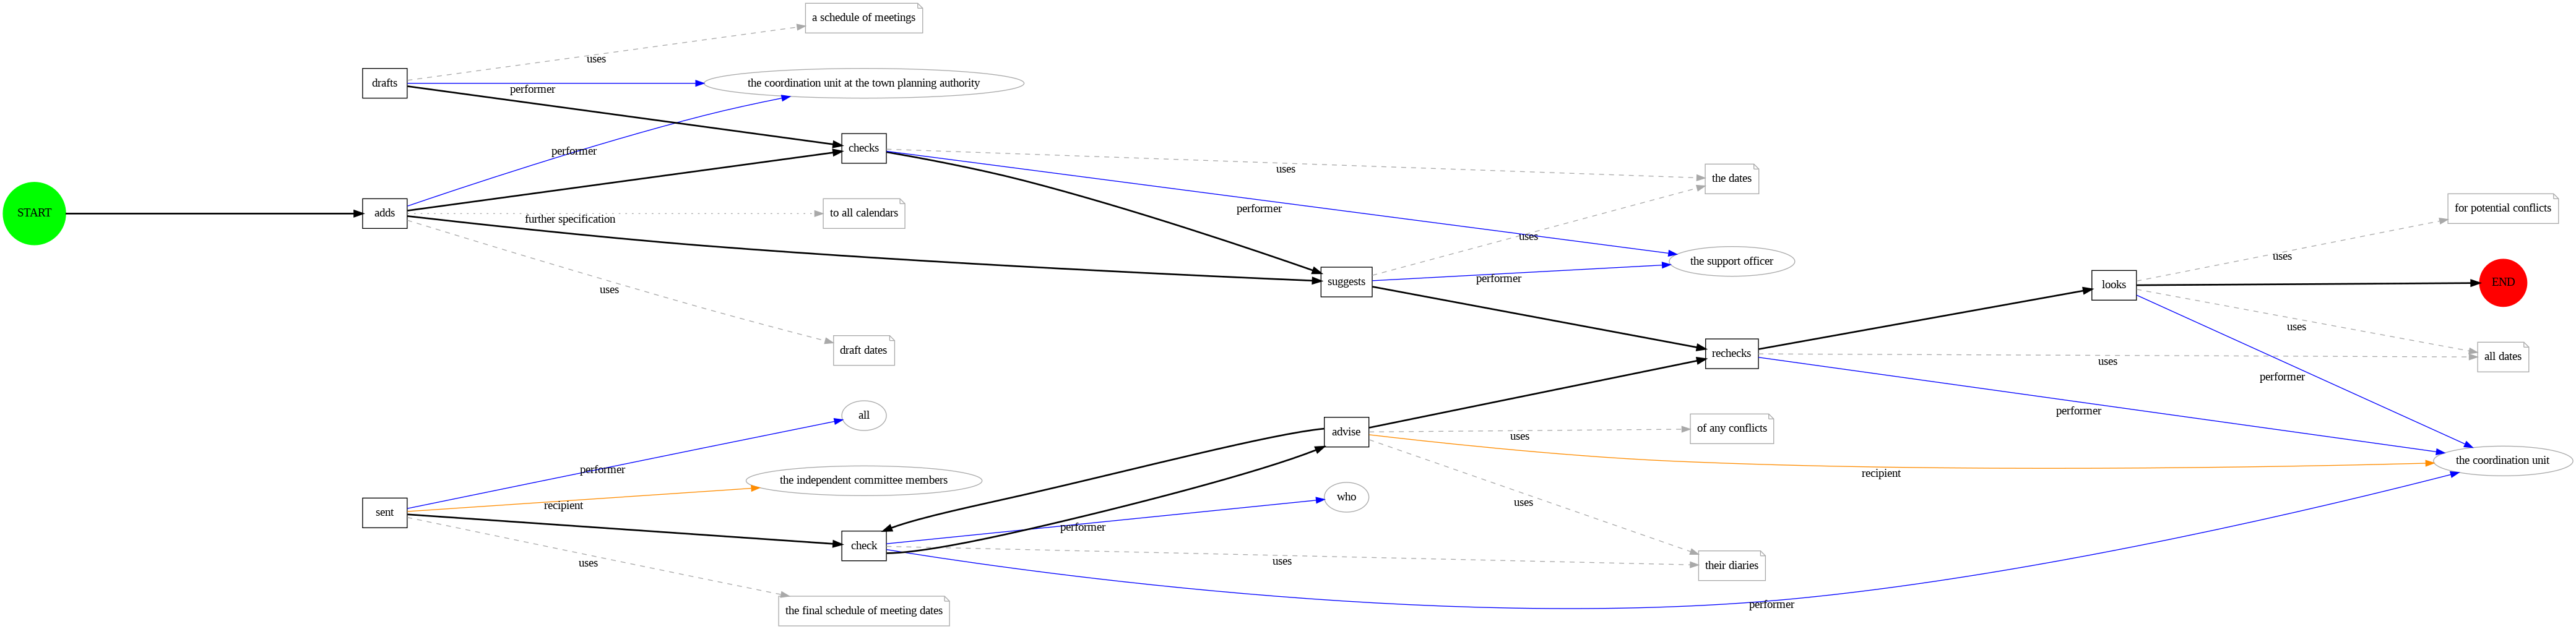

In [ ]:
#@title Generate the BPMN diagram to a png visualization
#Start creating the directed graph. Running this cell creates the dot graph and visualizes it in a png.



# Create a new directed graph: some examples of starting the dot graph with different 'attributes' for the sake of spacing between the nodes and edges

#dot = Digraph('BPMN Diagram', comment='Generated BPMN Diagram', graph_attr={'rankdir': 'LR', 'splines': 'ortho'})
#dot = Digraph('BPMN Diagram', comment='Generated BPMN Diagram', graph_attr={'rankdir': 'LR', 'nodesep': '1', 'ranksep': '1.2', 'overlap': 'scale', 'splines': 'ortho'})
#dot = Digraph('BPMN Diagram', comment='Generated BPMN Diagram', graph_attr={'rankdir': 'LR', 'nodesep': '2', 'splines': 'ortho', 'overlap': 'scale', 'ranksep': '1.2'})
dot = Digraph('BPMN Diagram',
              comment='Generated BPMN Diagram',
              graph_attr={
                  'rankdir': 'LR',    # Left to right graph
                  'nodesep': '0.6',     # Increase node separation
                  #'splines': 'ortho', # Use orthogonal lines
                  'overlap': 'False', # Scale overlap
                  'ranksep': '5',   # Increase rank separation
                  'fontsize': '12',   # Default text size
                  'fontname': 'Arial' # Default font
              })


# Track added nodes to avoid duplicates, this is a dictionary with as keys the 'tokens' and as values the 'chunk'
#added_nodes = {}
actors = []
activity_datas = []
XOR_gateways = []
AND_gateways = []
activities = []
specifications = []


#keep track of visited gateways
#open_gateways = []
#XOR_gateways = []

#keep track of condition specifications that have been visited
#specifications = []

#create the start event
dot.node('START', 'START', shape= node_styles.get('Start Event', 'box'), color= 'green', style='filled')

#find the first node to connect the start event with
starting_chunk = find_starting_chunk(BPMN_relations)
if starting_chunk:
  #print("The starting chunk is:", starting_chunk)
  add_node(starting_chunk)
  #create an edge between start event and the first node
  start_label, start_element_type, start_sent_id, start_tokenspan = starting_chunk
  starting_chunk_label = start_label + '_' + str(start_sent_id) + '_' + str(start_tokenspan[0])
  dot.edge('START', starting_chunk_label, style= 'bold')
else:
  print("Could not determine the starting chunk.")

# Add edges
for relation in BPMN_relations:
    source_chunk = relation['source_chunk']
    target_chunk = relation['target_chunk']
    relation_type = relation['relation_type']

    add_edge(source_chunk, target_chunk, relation_type, BPMN_relations)


#when all relations are processed add the END event node
dot.node('END', 'END', shape= 'circle', color='red', style='filled')

#Find the last_chunks to be connected to the END node
last_chunks = find_possible_last_chunks(BPMN_relations)
#print(f"these are the possible last chunks: {last_chunks}")

# Create a unique XOR Gateway if multiple last chunks exist
if len(last_chunks) > 1:
    xor_gateway_label = 'XOR_Join'
    dot.node(xor_gateway_label, 'X_join', shape='diamond')
    for last_chunk in last_chunks:
        last_label, last_element_type, last_sent_id, last_tokenspan = last_chunk
        last_chunk_label = last_label + '_' + str(last_sent_id) + '_' + str(last_tokenspan[0])
        dot.edge(last_chunk_label, xor_gateway_label, style='bold')
    # Finally, connect the XOR gateway to the end event
    dot.edge(xor_gateway_label, 'END', style='bold')
elif len(last_chunks) == 1: # Check if last_chunks is not empty
    # Direct connection if only one last chunk
    last_label, last_element_type, last_sent_id, last_tokenspan = last_chunks[0]
    last_chunk_label = last_label + '_' + str(last_sent_id) + '_' + str(last_tokenspan[0])
    dot.edge(last_chunk_label, 'END', style='bold')
else:
    print("No last chunks found. The diagram might be incomplete.") # Handle the case when no last chunks are found


#From here on, the BPMN diagram is generated.
#It could be that relations were missed and therefore some entities were not generated in the diagram.
#The following loop runs over every chunk in the mention_chunk list and checks if an element should be made.

for mention_chunk in mention_chunks:
    label, element_type, sent_id, tokenspan = mention_chunk

    add_node(mention_chunk)

    if element_type == 'Condition Specification' or element_type == 'Further Specification':
        if mention_chunk not in specifications:
            shape = node_styles.get(element_type, 'box')
            color = 'grey'
            display_label = label + '(' + element_type + ')'
            new_label = label + '_' + str(sent_id) + '_' + str(tokenspan[0])
            dot.node(new_label, display_label, shape=shape, color=color)
            specifications.append(mention_chunk)

    else:
      print("")

# render the graph to a png
png_data = dot.pipe(format='png')

# display the png_data from above
display(Image(png_data))

##5.3 SAVING all outputs and Changing the BPMN diagram
In the following box, there are several options for saving the dot graph as a:


*   png
*   html
*   svg
*   dot

The .dot file version of the dot graph is saved for the reason of easily changing within this file and reloading it in the next cell accordingly to the user preferences.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Assume 'dot' is your Digraph object from graphviz
#dot.format = 'png'  # Set the format to PNG
#dot.render('output_filename', cleanup=True)  # Render and save to file

#dot.render('doc-20.15_BPMN', format='png', cleanup=False) #this will create the png file as well as the intermediate files (not to be confused with the .dot file)

#dot.format = 'pdf'  # Set the format to PDF
#dot.render('output_filename', cleanup=True)  # Render and save to file

#dot.format = 'svg'  # Set the format to SVG
#dot.render('output_filename', cleanup=True)  # Render and save to file

#if preferred the graph can be saved to a html file
'''
# Generate SVG from your dot object
svg_output = dot.pipe(format='svg').decode('utf-8')

# HTML template to embed SVG
html_output = f"""
<html>
<head>
<title>Graphviz Diagram</title>
</head>
<body>
<h1>My Graphviz Graph</h1>
<div>{svg_output}</div>
</body>S
</html>
"""

# Write HTML to a file
with open('output.html', 'w') as f:
    f.write(html_output)'''

doc_name = document_name_selection[:-5]  # replace 'example_graph' with your actual document name
base_filename = copy.copy(doc_name + ".dot")
pipeline_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/" #adjust to correct file path if gold standard data is used or predictions

# Full path for the .dot file
full_path = os.path.join(pipeline_path, base_filename)

# Save the DOT file
with open(full_path, 'w') as f:
    f.write(dot.source)

# Render the graph to PNG and adjust filename path for proper saving
png_filename = os.path.splitext(base_filename)[0]
output_path = dot.render(filename=os.path.join(pipeline_path, png_filename), format='png', cleanup=False)

# Output paths
print(f"Generated image saved to: {output_path}")
print(f"DOT source file saved to: {full_path}")



Generated image saved to: /content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/document_6.png
DOT source file saved to: /content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/document_6.dot


Write away the non-resolved mentions and the resolved mentions for the test set documents. This is for documentation purposes.

In [ ]:
MENTIONS_base_filename = copy.copy(doc_name + "_MENTIONS" +".txt")
MENTIONS_pipeline_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/" #adjust to correct file path if gold standard data is used or predictions
MENTIONS_full_path = os.path.join(MENTIONS_pipeline_path, MENTIONS_base_filename)

with open(MENTIONS_full_path, 'w') as file:
    file.write("Pure output list of NER predictions per sentence: \n")
    file.write('\n')

    for sentence in NER_PRED_out:
        file.write(str(sentence))
        file.write('\n')

    file.write('____________________________________________________________________________________________\n')
    file.write("non-resolved mention chunks: \n")
    file.write('\n')
    for chunk in NER_prediction['pred_data']:
        file.write(str(chunk))
        file.write('\n')


    file.write('____________________________________________________________________________________________\n')
    file.write("resolved mention chunks: \n")
    file.write('\n')

    for chunk in resolved_NER:
        file.write(str(chunk))
        file.write('\n')



Write away the non-resolved relations and resolved relations for the test set. This is for documentation purposes.

In [ ]:
RELATIONS_base_filename = copy.copy(doc_name + "_RELATIONS" +".txt")
RELATIONS_pipeline_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/" #adjust to correct file path if gold standard data is used or predictions
RELATIONS_full_path = os.path.join(RELATIONS_pipeline_path, RELATIONS_base_filename)

with open(RELATIONS_full_path, 'w') as file:
    # Following lines are for visualization only:
    file.write("non-resolved relations: \n")
    for relation in predicted_relations:
        file.write(f"relation_type: {relation['relation_type']} ")
        file.write(f"\n")
        file.write(f"source_chunk: {relation['source_chunk']} ")
        file.write(f"\n")
        file.write(f"target_chunk: {relation['target_chunk']} ")
        file.write('\n')
        file.write('\n')
    file.write('____________________________________________________________________________________________\n')
    file.write("resolved relations: \n")
    file.write('\n')

    for relation in BPMN_relations:
        file.write(f"relation_type: {relation['relation_type']} ")
        file.write(f"\n")
        file.write(f"source_chunk: {relation['source_chunk']} ")
        file.write(f"\n")
        file.write(f"target_chunk: {relation['target_chunk']} ")
        file.write('\n')
        file.write('\n')

df_relations.to_csv(f"/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/{doc_name}_relations_DF.csv", index=False)
result_df.to_csv(f"/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/{doc_name}_result_relations_DF.csv", index=False)

Write away the clusters of the document. This is for documentation.

In [ ]:
cluster_base_filename = copy.copy(doc_name + "CLUSTERS" +".txt")
cluster_pipeline_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/PIPELINE_OUTPUTS/PREDICTIONS_ON_TEST/" #adjust to correct file path if gold standard data is used or predictions
cluster_full_path = os.path.join(cluster_pipeline_path, cluster_base_filename)

with open(cluster_full_path, 'w') as file:
    # Following lines are for visualization only:
    file.write("These were the original clusters (without user interference): \n")
    file.write("\n")

    for cluster in clusters_original:
        file.write(f"\nCluster {cluster['cluster_id']}:\n")
        for mention in cluster["mentions"]:
            file.write(str(mention) + '\n')

    if clusters == valid_clusters:
        file.write("\n The user did not change the clusters. \n")
    else:
        file.write("\n The user changed the clusters. \n")
        file.write('____________________________________________________________________________________________\n')
        file.write("These are the adapted clusters by the user: \n")
        file.write("\n")
        for cluster in valid_clusters:
          file.write(f"\nCluster {cluster['cluster_id']}:\n")
          for mention in cluster["mentions"]:
              file.write(str(mention) + '\n')



Now the .dot file can be changed accordingly

Open the corrected and saved version of the .dot file
Make a new rendering into a png file and display it.

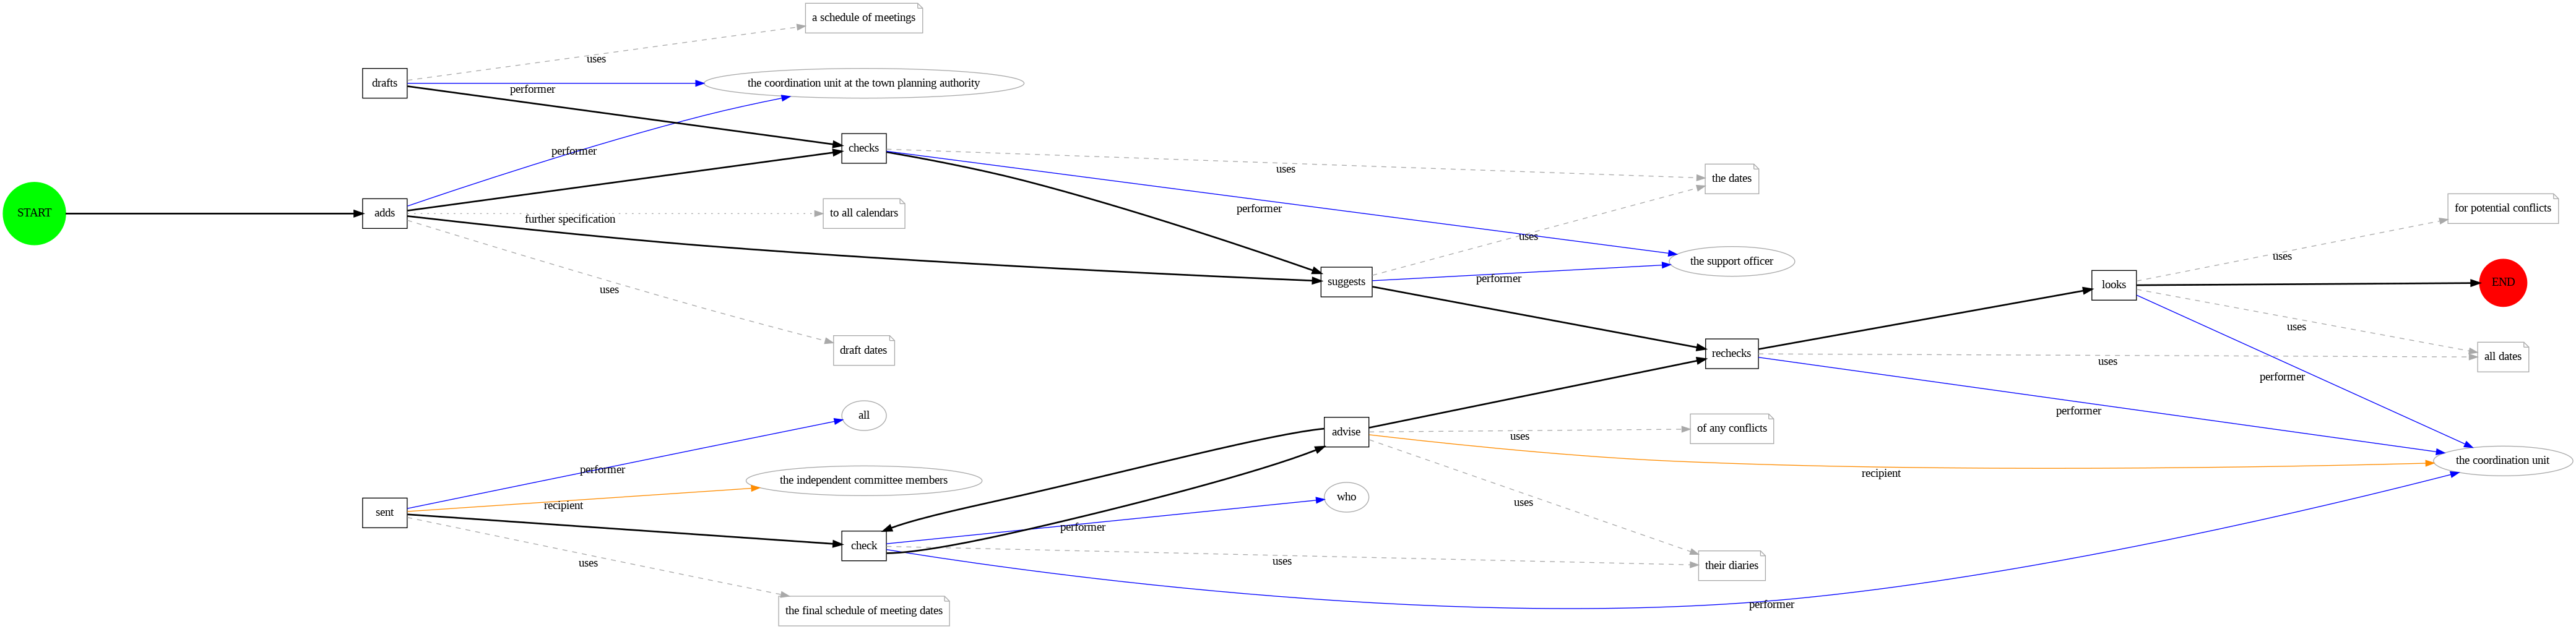

In [ ]:
from graphviz import Source
from IPython.display import Image, display

# Load the modified DOT file
#with open('/content/GOLD_document6_corrected.dot', 'r') as file:
    #dot_source = file.read()


with open(full_path, 'r') as file: #REPLACE the string with the correct document name of the corrected graph
    dot_source = file.read()

# Create a Source object
dot = Source(dot_source)

# Render the DOT source to a PNG file and display it
png_data = dot.pipe(format='png')
display(Image(png_data))

# Optionally, save the PNG file to colab environment
with open('corrected_BPMN.png', 'wb') as f:
    f.write(png_data)